# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from matplotlib.widgets import Slider, Button
from joblib import Parallel, delayed 
import matplotlib.animation as animation
import pandas as pd
from routines_model import *
from routines_GA import *

# %load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

# Model

## Age model

Text(0.5, 0, 'depth')

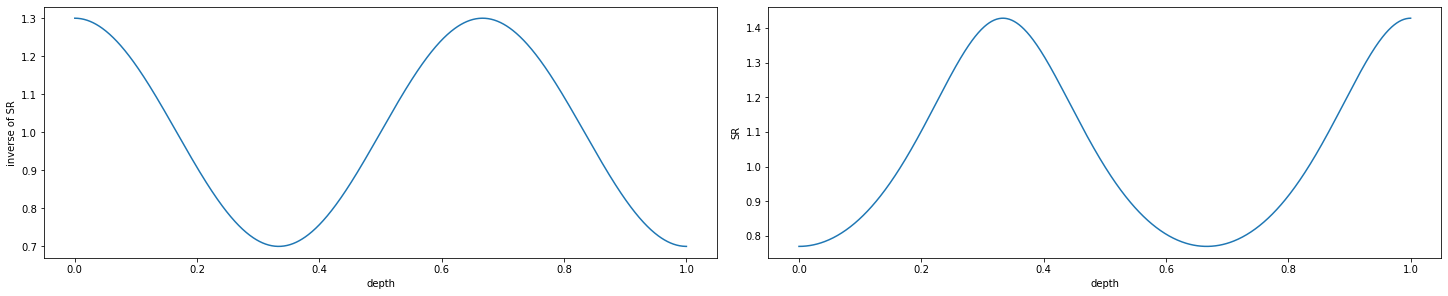

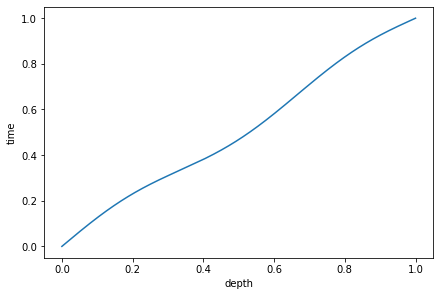

In [3]:
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=3)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=20)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=3)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
SR = 1/invSR
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

fig = plt.figure(figsize=(20,4), constrained_layout=True)
# fig.suptitle(f"{func_inv_SR.__name__}")
n = 2

plt.subplot(1,n,1)
plt.plot(depth, invSR)
plt.xlabel("depth")
plt.ylabel("inverse of SR")

plt.subplot(1,n,2)

plt.plot(depth, SR)
plt.xlabel("depth")
plt.ylabel("SR")


fig = plt.figure(figsize=(6,4), constrained_layout=True)

plt.plot(depth, time)
plt.ylabel("time")
plt.xlabel("depth")
# plt.savefig("figures/time_depth.png",dpi=300)

# plt.subplot(1,n,4)
# plt.plot(time, depth)
# plt.xlabel("time")
# plt.ylabel("depth")




Data

In [4]:
b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
p0 = 50.467718
muy_k = muy_k/180/3600*np.pi
muy_k = muy_k*1e6
p0 = p0/180/3600*np.pi
p0 = p0*1e6

phi_k = phi_k/180/3600*np.pi
phi_p = np.pi/2
# b_k
n_terms = 4
b_k = b_k[:n_terms]
muy_k = muy_k[:n_terms]
phi_k = phi_k[:n_terms]

fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi
fe_k = fe_k*1e6

In [5]:
phi_true = np.random.rand(n_terms)*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
X_true = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
# X = generate_X_linReg(b_k, muy_k+p0, time)

y_EP = X_true @ ABtrue
noise = np.random.randn(N_data)*1
y_model = y_EP
y = y_model + noise


Text(0.5, 0, 'depth')

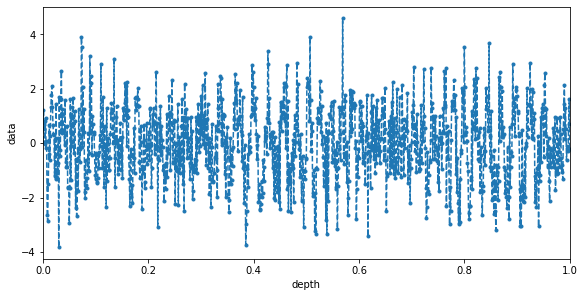

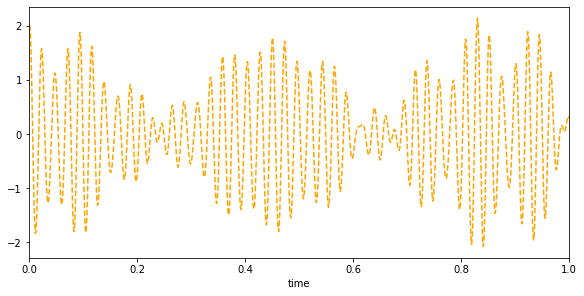

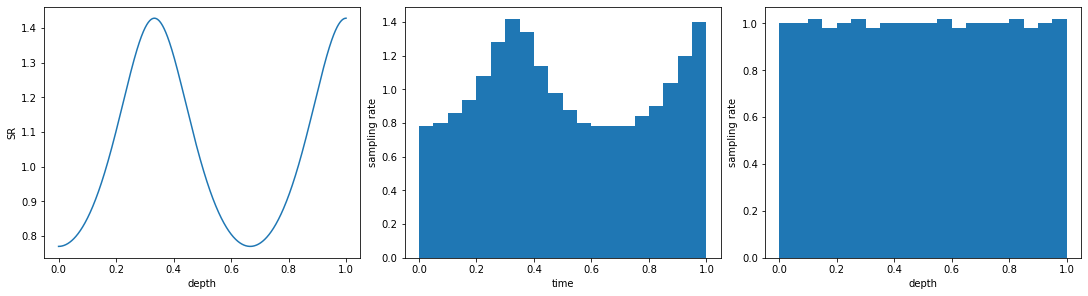

In [6]:
plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, "--.")
# plt.plot(depth, y_model,'--')
plt.xlim([0,1])
plt.xlabel("depth")
plt.ylabel("data")
plt.savefig("figures/ydata.png", dpi=300)
plt.figure(figsize=(8,4), constrained_layout=True)
# plt.plot(time, y)
plt.plot(time, y_model,'--',c="orange")
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
plt.xlabel("time")
# plt.ylabel("data")
plt.xlim([0,1])
# plt.savefig("figures/ymodel.png", dpi=300)

fig = plt.figure(figsize=(15, 4), constrained_layout=True)
n = 3
plt.subplot(1,n,1)
plt.plot(depth, 1/invSR)
plt.ylabel("SR")
plt.xlabel("depth")
plt.subplot(1,n,2)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,3)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

## Linear Regression

LR when SR is known

In [7]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
reg.fit(X, y)

print("score R2", reg.score(X,y))
print("AB")
print(ABtrue)
print(reg.coef_)
print("Amplitude")
print("True", ABtrue[:n_terms]**2+ABtrue[n_terms:]**2)
# print(b_k**2)
print("Pred", reg.coef_[:n_terms]**2+reg.coef_[n_terms:]**2)
# b_k**2
print("Phase")
print("True", np.arctan(ABtrue[n_terms:]/ABtrue[:n_terms])/(2*np.pi)*360)
print("Pred", np.arctan(reg.coef_[n_terms:]/reg.coef_[:n_terms])/(2*np.pi)*360)


score R2 0.4434652248510448
AB
[ 0.1571718   0.55316714 -0.33785772  0.40089321  0.84856704  0.49658394
  0.48783861  0.0327324 ]
[ 0.14233506  0.573299   -0.37942296  0.38269145  0.86656391  0.51317282
  0.47526432  0.18943667]
Amplitude
True [0.744769   0.5525895  0.35213435 0.16178678]
Pred [0.77119228 0.59201809 0.36983795 0.182339  ]
Phase
True [ 79.5065806   41.91465509 -55.29505864   4.66776978]
Pred [ 80.67232817  41.83243878 -51.39820092  26.33593906]


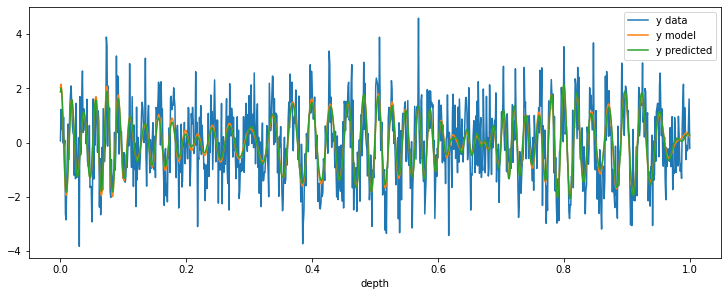

In [8]:
y_true = X @ ABtrue
y_pred = X @ reg.coef_

plt.figure(figsize=(10,4), constrained_layout=True)
plt.plot(depth, y, label="y data")
plt.plot(depth, y_pred, label="y model")
plt.plot(depth, y_true, label="y predicted")
plt.xlabel("depth")
plt.legend()
# plt.savefig("figures/predict_vs_true_true.png", dpi=200)

LR when SR is assumed to be constant, when in fact it is not

[-0.05742597 -0.10199616  0.0123311  -0.23568813  0.06565584  0.03636347
  0.08025911  0.10067715]
[ 0.1571718   0.55316714 -0.33785772  0.40089321  0.84856704  0.49658394
  0.48783861  0.0327324 ]
Amplitude
True [0.744769   0.5525895  0.35213435 0.16178678]
Pred [0.00760843 0.01172552 0.00659358 0.06568479]
Phase
True [ 79.5065806   41.91465509 -55.29505864   4.66776978]
Pred [-48.8253912  -19.62206809  81.26531696 -23.13036055]


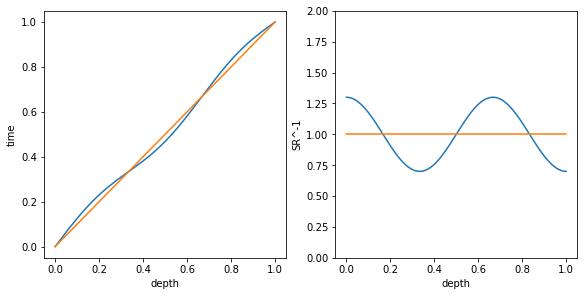

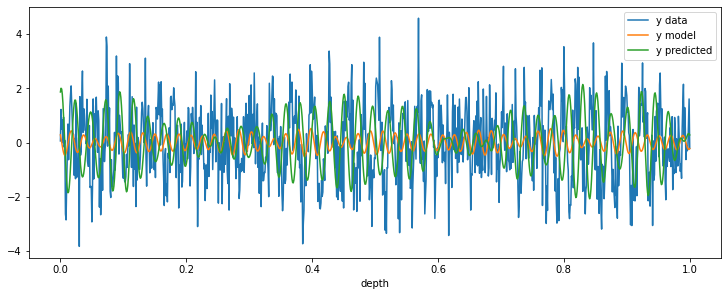

In [9]:
time_constant_SR = depth*1
plt.figure(figsize=(8,4), constrained_layout=True)
plt.subplot(1,2,1)
plt.xlabel("depth")
plt.plot(depth, time)
plt.ylabel("time")
plt.plot(depth, time_constant_SR)
plt.subplot(1,2,2)
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.plot(depth, invSR)
plt.plot(depth, np.ones_like(depth))
plt.ylim([0,2])
# plt.savefig("figures/SR_td.png", dpi=200)
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time_constant_SR)
reg.fit(X, y)
print(reg.coef_)
print(ABtrue)
print("Amplitude")
print("True", ABtrue[:n_terms]**2+ABtrue[n_terms:]**2)
# print(b_k**2)
print("Pred", reg.coef_[:n_terms]**2+reg.coef_[n_terms:]**2)
# b_k**2
print("Phase")
print("True", np.arctan(ABtrue[n_terms:]/ABtrue[:n_terms])/(2*np.pi)*360)
print("Pred", np.arctan(reg.coef_[n_terms:]/reg.coef_[:n_terms])/(2*np.pi)*360)



y_true = X @ ABtrue
y_pred = X @ reg.coef_

plt.figure(figsize=(10,4), constrained_layout=True)
plt.plot(depth, y, label="y data")
plt.plot(depth, y_pred, label="y model")
plt.plot(depth, y_true, label="y predicted")
plt.xlabel("depth")
plt.legend()
# plt.savefig("figures/predict_vs_true_timeopt.png", dpi=200)



# Genetic Algorithm (GA)

## Specification of operator

Metric and selection

In [13]:
selection_tournament(np.linspace(0,1,11), 10)

array([ 9,  9,  4,  9,  7,  8,  5, 10,  8,  5])

In [17]:
    
interpolator = interpolate_CubicSpline

# yp = np.gradient(t, depth[1]-depth[0])
metric([depth[::100], y[::100]], [depth, y], muy_k+p0, interpolator)

731.4332359586393

In [172]:
%lprun -f metric metric([depth[::100], y[::100]], [depth, y], muy_k+p0, interpolator)

Timer unit: 1e-09 s

Total time: 0.00534295 s
File: /tmp/ipykernel_1963069/1442845180.py
Function: metric at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def metric(invSR, data, fs, interpolator=interpolate_CubicSpline, metric_type="BIC", *args, **kwargs):
    20                                               """_summary_: 
    21                                               
    22                                                   metric  (according to the metric type) for the linear model with predictors variable are fourier harmonics of frequencies fs
    23                                                   of fitting the data, when used the age model derived from the invSR.
    24                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
    25                                                   to obtain time.
    26   

Crossover

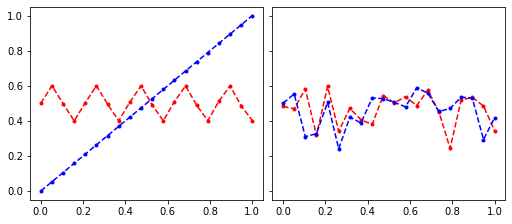

In [20]:

# TEST crossover_blended
x = np.linspace(0,1,20)
x1 = np.sin(30*x)*0.1+0.5
x2 = x*1
# x2 = np.ones_like(x)
# x2 = np.cos(10*x)+1
x1_x, x2_x = crossover_blend(x1, x2, 0.5, [0.2,0.6])
fig, axs =plt.subplots(1,2,figsize=(7,3),sharey=True,constrained_layout=True)
axs[0].plot(x,x1, "--.r")
axs[0].plot(x,x2, "--.b")
axs[1].plot(x,x1_x, "--.r")
axs[1].plot(x,x2_x, "--.b")
# axs[1].plot(x1_x[0],x1_x[1], "r--", x2_x[0], x2_x[1], "b--")




Mutation

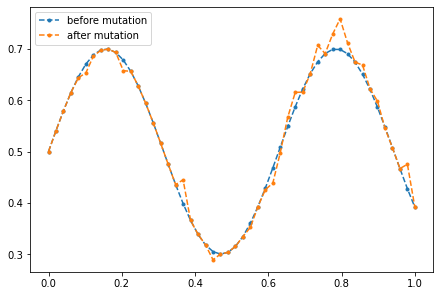

In [19]:

#TEST 1
# x = np.linspace(0,1,50)
# x1 = np.vstack([x,np.sin(10*x)])
# x1_x = mutation(x1, 0.5, yrange=[-1,1])
# plt.plot(x1[0],x1[1])
# plt.plot(x1_x[0],x1_x[1],'.')


# TEST mutation_poly
# x = np.linspace(0,1,50)
# x1 = np.sin(10*x)*0.2+0.5
# x1_x = mutation_poly(x1, 0.9, xrange=[0,2], eta=50)
# plt.plot(x, x1)
# plt.plot(x, x1_x)
# plt.plot(x, x1-x1_x)
# plt.plot(x1_x[0],x1_x[1])

#TEST mutation_poly_pop
plt.figure(constrained_layout=True)
x = np.linspace(0,1,50)
x1 = np.sin(10*x)*0.2+0.5
X = np.vstack([x1,x1,x1,x1])
X_x = mutation_pop(X, np.array([0,1,1,1]), xrange=[0,2], eta=50)
plt.plot(x, x1,'.--', label="before mutation")
plt.plot(x, X_x[0],'.--', label="after mutation")
plt.legend()
# plt.savefig("figures/mutation.png",dpi=200)
# plt.plot(x, X_x[1],'.--')

# In action

## Problem

In [5]:
np.random.seed(126)
"Generate an age model"
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=8)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
SR = 1/invSR
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

"""Generate an data"""

"EP model"
phi_true = np.random.rand(n_terms)*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
fs = muy_k + p0
X_true = generate_X_linReg(np.ones_like(muy_k), fs, time)

y_EP = X_true @ ABtrue
noise = np.random.randn(N_data)*1
y_model = y_EP
y = y_model + noise

# "simple model"
# f1 = 100; f2= 4.3*100
# A1 = 1; A2 = 1.2
# y_model = A1*np.cos(f1*time) + A2*np.cos(f2*time)
# fs =  np.array([f1, f2])
# y = y_model + noise


Text(0.5, 0, 'depth')

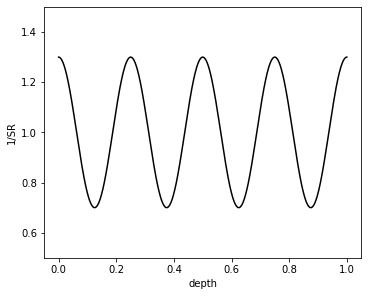

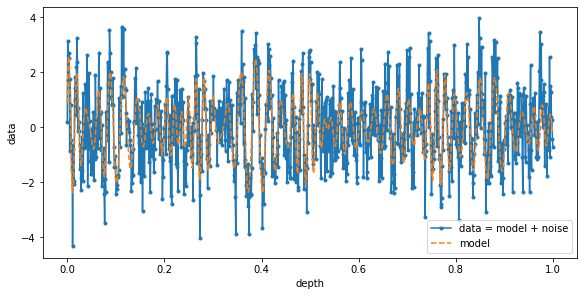

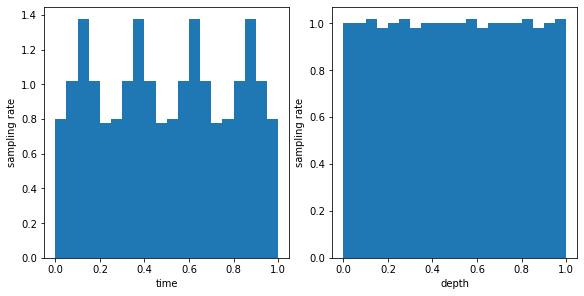

In [6]:
"plot"
# plt.subplots(1,2)
plt.figure(figsize=(5,4), constrained_layout=True)
plt.subplot(1,1,1)
plt.plot(depth, invSR, color="black")
# plt.ylim([0,2])
plt.ylim([0.5,1.5])

plt.xlabel("depth")
plt.ylabel("1/SR")
# plt.subplot(1,2,2)
# plt.xlabel("depth")
# plt.ylabel("time")
# plt.plot(depth, time, color="black")
plt.savefig("figures/invSR_sinek3.png",dpi=200)


plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()
# plt.savefig("figures/data_sinek3.png",dpi=200)
# plt.figure(figsize=(15,4))
# plt.plot(time, y)
# plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
# plt.xlabel("time")
# plt.ylabel("data")

plt.figure(figsize=(8,4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

## Search

In [7]:
def GA_search_v1(data, fs, interpolator, depth_grid, N_population, N_generations_max, invSR_lims, initializer="Sobol"):
    # eps = 1e-4
    N_genes = len(depth_grid)
    # depth_grid = np.linspace(0,1,N_genes)
    # depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])

    if initializer == "Sobol" : 
        sampler = sp.stats.qmc.Sobol(d=N_genes)
        invSR_ini = sampler.random_base2(m=int(np.log2(N_population)))*invSR_lims[1]
    elif initializer == "random" :
        invSR_ini = np.random.rand(N_population,N_genes)*invSR_lims[1]
    invSR_all = np.zeros((N_generations_max,N_population,N_genes))
    invSR_all[0] = invSR_ini
    metric_all = np.zeros((N_generations_max,N_population))
    metric0 = partial(metric, data=data, fs=fs, interpolator=interpolator, metric_type="BIC")
    metric_ini = np.array([metric0([depth_grid, invSR_ini_i]) for invSR_ini_i in invSR_ini])
    metric_all[0] = metric_ini
    n_generations = N_generations_max
    for i in range(N_generations_max-1):
        invSR_i = invSR_all[i]
        metric_i = metric_all[i]
        if metric_i.min() ==  metric_i.max():
            n_generations = i+1
            break
        selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
        invSR_ip = crossover_pop(invSR_i[selected_inds], -metric_i[selected_inds], crossover_operator=crossover_blend)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        # metric_ip = metric_all[i]
        invSR_ip = mutation_pop(invSR_ip, -metric_ip, mutation_operator=mutation_poly, xrange=invSR_lims, eta=20)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        metric_all[i+1] = metric_ip
        invSR_all[i+1] = invSR_ip
    print(n_generations)
    metric_all = metric_all[:n_generations]
    invSR_all = invSR_all[:n_generations]
    return invSR_all, metric_all 


def GA_search_v2(data, fs, interpolator, depth_grid, N_population, N_generations_max, invSR_lims, initializer="Sobol"):
    """Similar to GA_search_v1, but when std(fitness) < eps: reinitialize the population while keeping the best individual

    """
    eps = 1
    N_genes = len(depth_grid)
    # depth_grid = np.linspace(0,1,N_genes)
    # depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])

    invSR_all = np.zeros((N_generations_max,N_population,N_genes))
    if initializer == "Sobol" : 
        sampler = sp.stats.qmc.Sobol(d=N_genes)
        invSR_ini = sampler.random_base2(m=int(np.log2(N_population)))*invSR_lims[1]
    elif initializer == "random" :
        invSR_ini = np.random.rand(N_population,N_genes)*invSR_lims[1]

    invSR_all[0] = invSR_ini
    metric_all = np.zeros((N_generations_max,N_population))
    metric0 = partial(metric, data=data, fs=fs, interpolator=interpolator, metric_type="BIC")
    metric_ini = np.array([metric0([depth_grid, invSR_ini_i]) for invSR_ini_i in invSR_ini])
    metric_all[0] = metric_ini
    n_generations = N_generations_max
    for i in range(N_generations_max-1):
        invSR_i = invSR_all[i]
        metric_i = metric_all[i]
        
        if np.std(metric_i) < eps:
            best_individual = invSR_i[np.argmin(metric_i)] 
            if initializer == "Sobol" : 
                sampler = sp.stats.qmc.Sobol(d=N_genes)
                invSR_i = sampler.random(N_population)*invSR_lims[1]
            elif initializer == "random" :
                invSR_i = np.random.rand(N_population,N_genes)*invSR_lims[1]
            invSR_i[0] = best_individual
            metric_i = np.array([metric0([depth_grid, invSR_i_i]) for invSR_i_i in invSR_i])
        # if metric_i.min() ==  metric_i.max():
        #     n_generations = i+1
        #     break
        selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
        invSR_ip = crossover_pop(invSR_i[selected_inds], -metric_i[selected_inds], crossover_operator=crossover_blend)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        invSR_ip = mutation_pop(invSR_ip, -metric_ip, mutation_operator=mutation_poly, xrange=invSR_lims, eta=20)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        metric_all[i+1] = metric_ip
        invSR_all[i+1] = invSR_ip
            
    # print(n_generations)
    metric_all = metric_all[:n_generations]
    invSR_all = invSR_all[:n_generations]
    return invSR_all, metric_all 

def GA_search_v3(data, fs, interpolator, depth_grid, N_population, N_generations_max, invSR_lims, initializer="Sobol"):
    """Similar to GA_search_v1, but for every K interations: reinitialize the population while keeping the best k individuals

    """
    k = 10; K=10
    eps = 1
    N_genes = len(depth_grid)
    # depth_grid = np.linspace(0,1,N_genes)
    # depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])

    invSR_all = np.zeros((N_generations_max,N_population,N_genes))
    if initializer == "Sobol" : 
        sampler = sp.stats.qmc.Sobol(d=N_genes)
        invSR_ini = sampler.random_base2(m=int(np.log2(N_population)))*invSR_lims[1]
    elif initializer == "random" :
        invSR_ini = np.random.rand(N_population,N_genes)*invSR_lims[1]

    invSR_all[0] = invSR_ini
    metric_all = np.zeros((N_generations_max,N_population))
    metric0 = partial(metric, data=data, fs=fs, interpolator=interpolator, metric_type="BIC")
    metric_ini = np.array([metric0([depth_grid, invSR_ini_i]) for invSR_ini_i in invSR_ini])
    metric_all[0] = metric_ini
    n_generations = N_generations_max
    for i in range(N_generations_max-1):
        invSR_i = invSR_all[i]
        metric_i = metric_all[i]
        
        if (i+1)%K ==0:
            best_individuals = invSR_i[np.argpartition(metric_i, k)[:k]] 
            if initializer == "Sobol" : 
                sampler = sp.stats.qmc.Sobol(d=N_genes)
                invSR_i = sampler.random(N_population)*invSR_lims[1]
            elif initializer == "random" :
                invSR_i = np.random.rand(N_population,N_genes)*invSR_lims[1]
            invSR_i[:k] = best_individuals
            metric_i = np.array([metric0([depth_grid, invSR_i_i]) for invSR_i_i in invSR_i])
        # if metric_i.min() ==  metric_i.max():
        #     n_generations = i+1
        #     break
        selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
        invSR_ip = crossover_pop(invSR_i[selected_inds], -metric_i[selected_inds], crossover_operator=crossover_blend)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        invSR_ip = mutation_pop(invSR_ip, -metric_ip, mutation_operator=mutation_poly, xrange=invSR_lims, eta=20)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        metric_all[i+1] = metric_ip
        invSR_all[i+1] = invSR_ip
            
    # print(n_generations)
    metric_all = metric_all[:n_generations]
    invSR_all = invSR_all[:n_generations]
    return invSR_all, metric_all 

GA_search = GA_search_v1


In [8]:
N_population = 128 # number of individual in population 
N_generations_max = 100
N_genes = 15 # number of intial gene in an individial of the population 
depth_grid = np.linspace(0,1,N_genes)
# depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])
# depth_grid = 0.5 + 0.5*np.cos((2*(np.arange(N_genes)+1)-1)/(2*N_genes)*np.pi); depth_grid = depth_grid[::-1]  #Chebysev nodes
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
metric_min = metric([depth_grid, func_inv_SR(depth_grid)], [depth, y], fs, interpolator, metric_type="BIC")
print(metric_min)
invSR_all = np.zeros((N_generations_max, N_population, N_genes))
invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
invSR_all[0] = invSR_ini
metric_all = np.zeros((N_generations_max, N_population))
metric_ini = np.array([metric([depth_grid, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
metric_all[0] = metric_ini

204.72708633877912


In [9]:

# GA_search()

kwargs = {
    "data": [depth, y],
    "fs" : fs,
    "interpolator":interpolator,
    "depth_grid":depth_grid,
    "N_population":N_population,
    "N_generations_max":N_generations_max,
    "invSR_lims":invSR_lims,
    "initializer":"random",
}

GA_search_data = partial(GA_search,  **kwargs)
n_jobs = 100
n_total_population = 100
res = Parallel(n_jobs=n_jobs, verbose=100)(delayed(GA_search_data)() for _ in range(n_total_population))
invSR_all_para = [item[0] for item in res]
metric_para = [item[1] for item in res]

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
13
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   10.0s
19
16
[Parallel(n_jobs=100)]: Done   3 out of 100 | elapsed:   10.9s remaining:  5.9min
20
17
[Parallel(n_jobs=100)]: Done   5 out of 100 | elapsed:   11.4s remaining:  3.6min
17
19
[Parallel(n_jobs=100)]: Done   7 out of 100 | elapsed:   11.7s remaining:  2.6min
18
20
[Parallel(n_jobs=100)]: Done   9 out of 100 | elapsed:   12.1s remaining:  2.0min
22
19
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   12.4s remaining:  1.7min
20
26
[Parallel(n_jobs=100)]: Done  13 out of 100 | elapsed:   13.0s remaining:  1.5min
21
22
[Parallel(n_jobs=100)]: Done  15 out of 100 | elapsed:   13.2s remaining:  1.3min
21
24
[Parallel(n_jobs=100)]: Done  17 out of 100 | elapsed:   13.5s remaining:  1.1min
19
23
[Parallel(n_jobs=100)]: Done  19 out of 100 | elapsed:   13.7s remaining:   58.3s
24
23
[Parallel(n_jobs=100)]: Done  21 out of 100 | elapsed:   

#  Result

## One population study

In [26]:
n_para = len(metric_para)
metric_last = np.array([metric_para[i][-1] for i in range(n_para)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
best_invSR = invSR_interpolate_par[np.argmin(metric_last.min(axis=1))]

In [27]:
i_pop = np.argmin(metric_last.min(axis=1))
i_pop = 2
invSR_all = invSR_all_para[i_pop]
metric_all = metric_para[i_pop]
n_gen, n_pop, n_genes = invSR_all.shape
invSR_all_interpolate = np.zeros((n_gen, n_pop, len(depth)))
for i in range(n_gen):
    for j in range(n_pop):
        invSR_all_interpolate[i,j] = interpolator([depth_grid, invSR_all[i,j]], depth)
# invSR_all_interpolate = np.array([[interpolator([depth_grid, invSR_all[i,j]),] ])

Text(0.5, 0, 'generations')

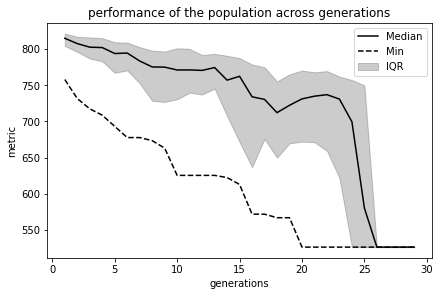

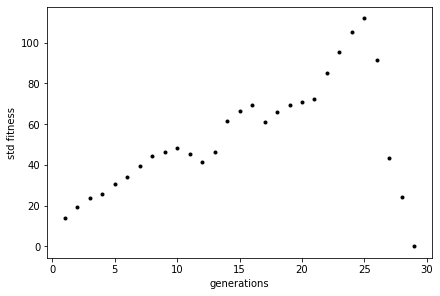

In [28]:
inds_generation = np.arange(1,n_gen+1)
# plt.plot(inds_generation, metric_all.mean(axis=1))
# plt.plot(inds_generation, metric_all.max(axis=1))
# plt.plot(inds_generation, metric_all.min(axis=1))
quantile_range = [0.25, 0.75]
metric_lo_up = np.quantile(metric_all, quantile_range, axis=1)
fig = plt.figure(constrained_layout=True)
plt.title("performance of the population across generations")
plt.plot(inds_generation, np.median(metric_all, axis=1), zorder=10,color="black", label="Median")
plt.plot(inds_generation, np.min(metric_all, axis=1), "--", zorder=10,color="black", label="Min")

plt.fill_between(inds_generation, *metric_lo_up, alpha=0.2, color="black", label="IQR")
plt.xlabel("generations")
plt.ylabel("metric")
plt.legend()
fig = plt.figure(constrained_layout=True)
plt.plot(inds_generation, np.std(metric_all, axis=1), ".", zorder=10,color="black", label="Median")
plt.ylabel("std fitness")
plt.xlabel("generations")

# plt.savefig("figures/metric_pop.png", dpi=200)

Text(0.5, 0, 'generations')

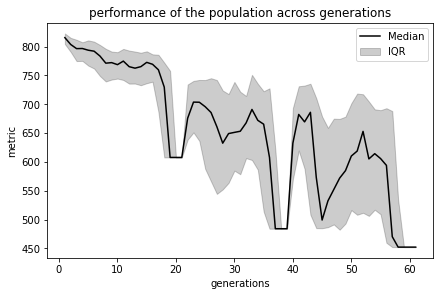

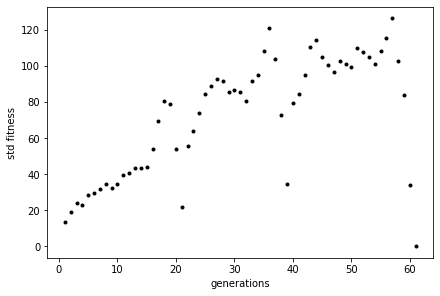

In [112]:
inds_generation = np.arange(1,n_gen+1)
# plt.plot(inds_generation, metric_all.mean(axis=1))
# plt.plot(inds_generation, metric_all.max(axis=1))
# plt.plot(inds_generation, metric_all.min(axis=1))
quantile_range = [0.25, 0.75]
metric_lo_up = np.quantile(metric_all, quantile_range, axis=1)
fig = plt.figure(constrained_layout=True)
plt.title("performance of the population across generations")
plt.plot(inds_generation, np.median(metric_all, axis=1), zorder=10,color="black", label="Median")
plt.fill_between(inds_generation, *metric_lo_up, alpha=0.2, color="black", label="IQR")
plt.xlabel("generations")
plt.ylabel("metric")
plt.legend()
fig = plt.figure(constrained_layout=True)
plt.plot(inds_generation, np.std(metric_all, axis=1), ".", zorder=10,color="black", label="Median")
plt.ylabel("std fitness")
plt.xlabel("generations")

# plt.savefig("figures/metric_pop.png", dpi=200)

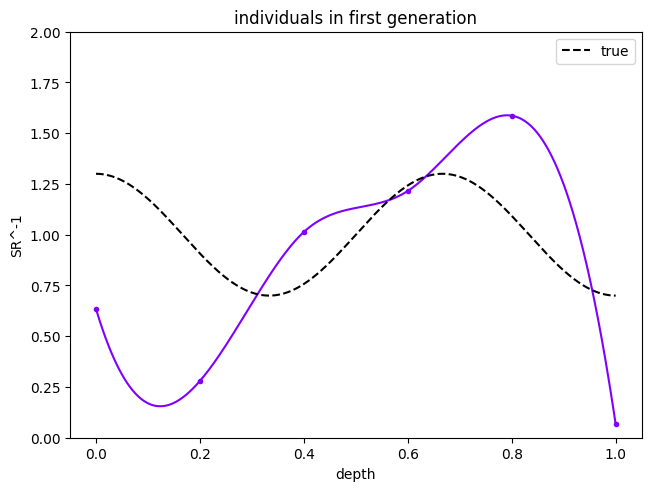

In [41]:
metric_all.shape
fig = plt.figure(constrained_layout=True)
cmap = plt.get_cmap("rainbow")
for i in range(1):
    i = 5
    # arg_best = np.argmin(metric_all[i])
    # arg_med = np.argsort(metric_all[i])[n_pop//2]
    plt.plot(depth_grid, invSR_all[0,i], ".", color=cmap(0/n_gen))
    plt.plot(depth, invSR_all_interpolate[0, i], color=cmap(0/n_gen))
plt.plot(depth, invSR, "--", color="black", label="true")
# plt.xlim([0,1])
plt.ylim([0,2])
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.title("individuals in first generation")
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(1,n_gen), cmap=cmap), label="generations")
plt.savefig("figures/invSR_gen1_1.png", dpi=200)
plt.legend()
# plt.colorbar(cmap)
# plt.savefig("figure")

C:\Users\hhnam\AppData\Local\Temp\ipykernel_27304\4265474684.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(1,n_gen), cmap=cmap), label="generations")


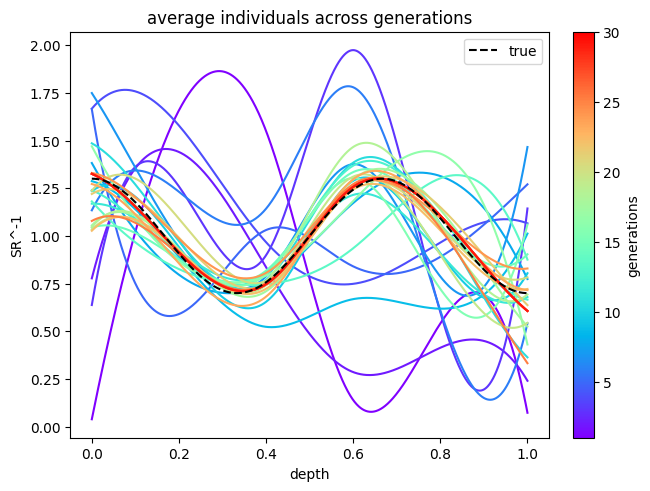

In [163]:
metric_all.shape
fig = plt.figure(constrained_layout=True)
cmap = plt.get_cmap("rainbow")
for i in range(n_gen):
# for i in range(20, 50):
    arg_best = np.argmin(metric_all[i])
    arg_med = np.argsort(metric_all[i])[n_pop//2]
    plt.plot(depth, invSR_all_interpolate[i, arg_med], color=cmap(i/n_gen))
plt.plot(depth, invSR, "--", color="black", label="true")
# plt.xlim([0,1])
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.title("average individuals across generations")
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(1,n_gen), cmap=cmap), label="generations")
# plt.savefig("figures/invSR_average.png", dpi=200)
plt.legend()
# plt.colorbar(cmap)
# plt.savefig("figure")

Animation

MovieWriter ffmpeg unavailable; using Pillow instead.


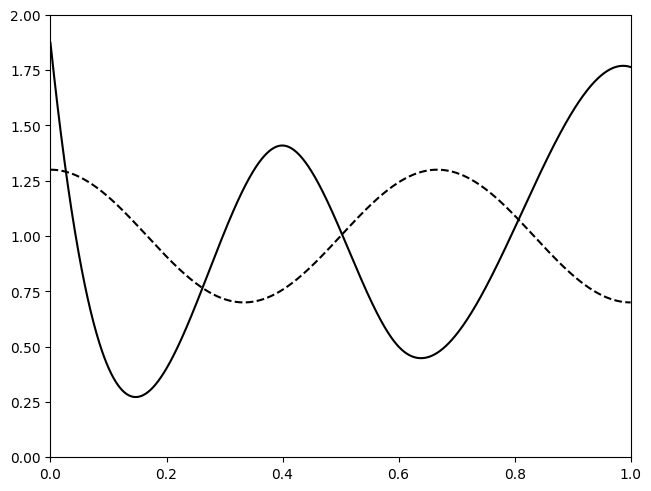

In [129]:
fig, ax = plt.subplots(1, 1, constrained_layout=True) # initialise la figure
line1, = plt.plot([], [], color="black") 
line2, = plt.plot([], [], "--", color="black") 
gen_text = ax.text(.8, .9, "", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 2)
args_best = np.argmin(metric_all, axis=1)
def animate(i): 
    arg_best = np.argmin(metric_all[i])
    arg_med = np.argsort(metric_all[i])[n_pop//2]
    line2.set_data(depth, invSR)
    line1.set_data(depth, invSR_all_interpolate[i,arg_med])
    return line2, line1,
 
ani = animation.FuncAnimation(fig, animate, frames=n_gen, blit=False, interval=200, repeat=True)
ani.save("animation.gif", dpi=200) 
# ani.savSD
# plt.show()

In [60]:
# line1
# lines = plt.plot(np.empty((0, 10)), np.empty((0, 10)))
# lines

In [173]:
invSR_all.shape

(30, 100, 6)

MovieWriter ffmpeg unavailable; using Pillow instead.


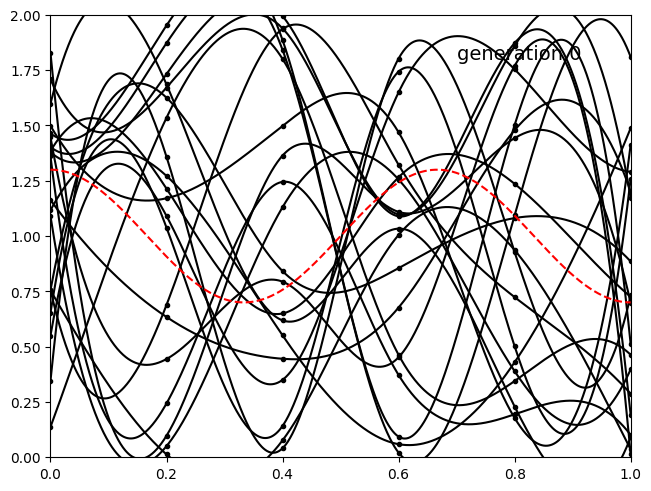

In [177]:
fig, ax = plt.subplots(1, 1, constrained_layout=True) # initialise la figure
n_reps = 20
line1, = plt.plot([], [], color="black") 
lines = plt.plot(np.empty((0, n_reps)), np.empty((0, n_reps)), color="black") 
dots = plt.plot(np.empty((0, n_reps)), np.empty((0, n_reps)), "." ,color="black") 

line2, = plt.plot(depth, invSR, "--", color="red", zorder=100) 

gen_text = ax.text(.7, .9, "", fontsize=14, transform=ax.transAxes)

plt.xlim(0, 1)
plt.ylim(0, 2)
args_best = np.argmin(metric_all, axis=1)
def animate(i): 
    gen_text.set_text(f"generation {i}")
    arg_best = np.argmin(metric_all[i])
    arg_med = np.argsort(metric_all[i])[n_pop//2]
    # line1.set_data(depth, invSR_all_interpolate[i,arg_med])
    
    for j, line in enumerate(lines):
        line.set_data(depth, invSR_all_interpolate[i, j])
        dots[j].set_data(depth_grid, invSR_all[i,j])
    return line1, lines, dots
 
ani = animation.FuncAnimation(fig, animate, frames=n_gen, blit=False, interval=300, repeat=True)
ani.save("animation.gif", dpi=200) 
# ani.savSD
# plt.show()

In [554]:
invSR_all_interpolate.shape

(100, 100, 1001)

In [556]:
# invSR_interpolate = interpolator([depth_grid, mean_invSR], depth)
# invSR_interpolate[invSR_interpolate<0] = 0
# invSR = invSR_interpolate_par[2]
invSRx = invSR_all_interpolate[-1,0]
time = sp.integrate.cumulative_trapezoid(invSRx, depth, initial=0)
X = generate_X_linReg(np.ones_like(fs), fs, time)

reg_model = LinearRegression().fit(X, y)
# Residual Sum Square
# RSS = np.sum((y_data - reg_model.predict(X))**2)

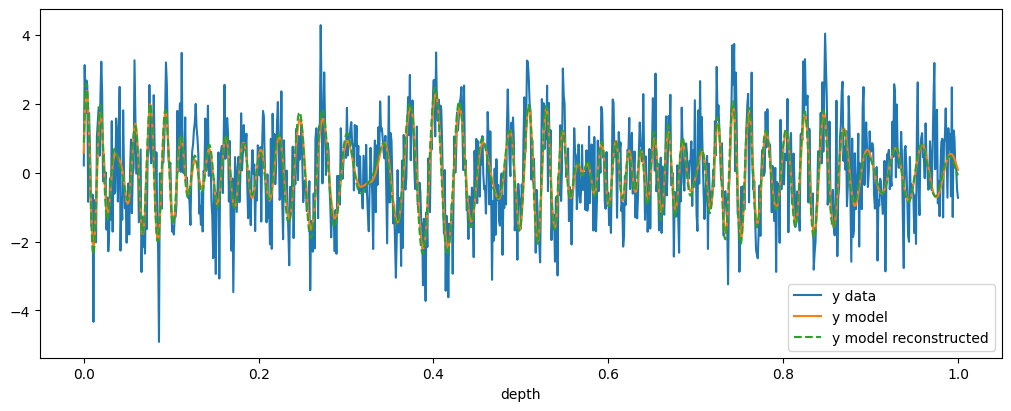

In [564]:
y_true = X @ ABtrue
y_pred = X @ reg_model.coef_

plt.figure(figsize=(10,4), constrained_layout=True)
plt.plot(depth, y, label="y data")
plt.plot(depth, y_pred, label="y model")
plt.plot(depth, y_true, "--",label="y model reconstructed")
plt.xlabel("depth")
plt.legend()
plt.savefig("figures/predict_vs_true_true_x.png", dpi=200)

## Multiple-population

In [84]:
def plot_MPGA(invSR_all_para, metric_para):
    n_para = len(metric_para)
    metric_last = np.array([metric_para[i][-1] for i in range(n_para)])
    metric_best = metric_last.min(axis=1)
    # invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
    invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
    # invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

    invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
    mean_invSR = np.median(invSR_interpolate_par,axis=0)
    invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)
    len_par = np.array([invSR_all.shape[0] for i, invSR_all in enumerate(invSR_all_para)])
    best_invSR = invSR_interpolate_par[np.argmin(metric_last.min(axis=1))]


    fig1 = plt.figure(constrained_layout=True)
    plt.title(f"estimation from {n_para} populations")
    plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
    plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

    plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
    plt.plot(depth, invSR, "--", color="red", label="true")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")
    plt.legend()
    # plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

    fig2 = plt.figure(constrained_layout=True)
    [plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
    plt.plot(depth, invSR, "--", color="black")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")

    fig3 = plt.figure(constrained_layout=True)
    plt.subplot(1,2,1)
    plt.hist(metric_best, color="black")
    plt.xlabel("metric")
    plt.ylabel("# population")
    plt.subplot(1,2,2)
    plt.plot(len_par, metric_best, '.', color="black")
    return fig1, fig2, fig3

Line

Text(0, 0.5, 'SR^-1')

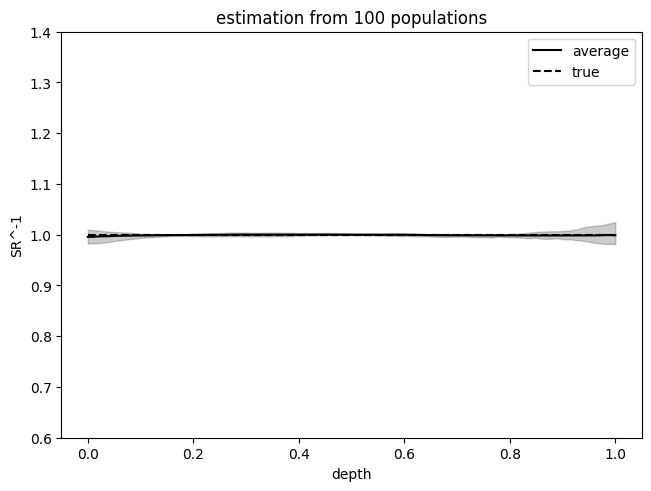

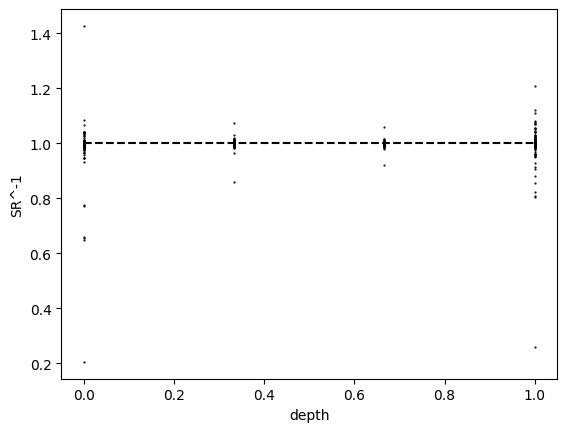

In [210]:
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.2, 0.8],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, , "--", color="red", label="true")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.ylim([0.6, 1.4])
plt.savefig("figures/invSR_all_populations_constant.png", dpi=200)
plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")
# plt.figure()
# plt.plot(depth, invSR, zorder=1000)
# for i in range(10):
#     # plt.plot(depth_grid, invSR_all_para[i][-1][0], '.')
#     plt.plot(depth, invSR_interpolate_par[i])


Text(0, 0.5, 'SR^-1')

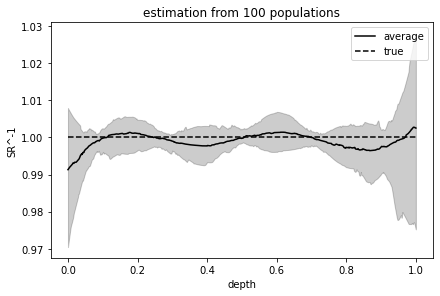

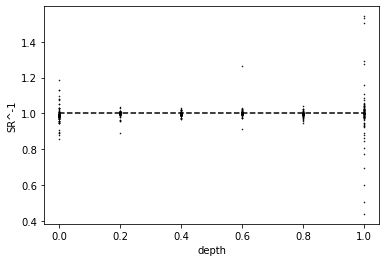

In [163]:
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.2, 0.8],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.savefig("figures/invSR_all_populations_constant.png", dpi=200)
plt.ylim([0.6, 1.4])
plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")
# plt.figure()
# plt.plot(depth, invSR, zorder=1000)
# for i in range(10):
#     # plt.plot(depth_grid, invSR_all_para[i][-1][0], '.')
#     plt.plot(depth, invSR_interpolate_par[i])


Text(0, 0.5, 'SR^-1')

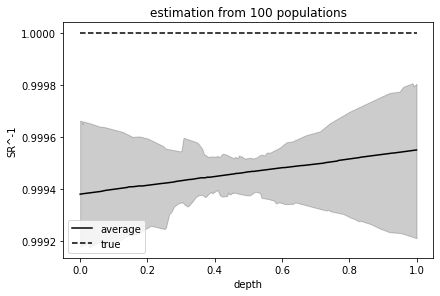

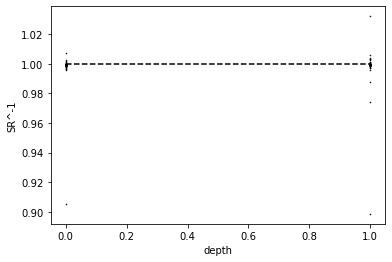

In [169]:
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.2, 0.8],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")
# plt.figure()
# plt.plot(depth, invSR, zorder=1000)
# for i in range(10):
#     # plt.plot(depth_grid, invSR_all_para[i][-1][0], '.')
#     plt.plot(depth, invSR_interpolate_par[i])


Text(0, 0.5, '# population')

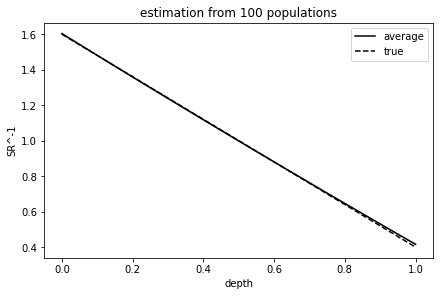

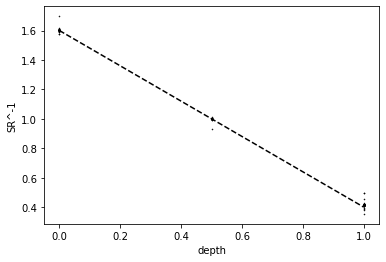

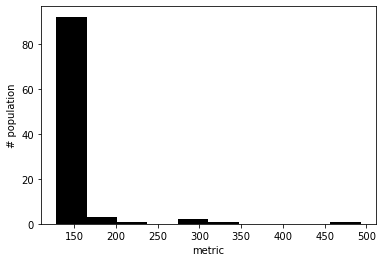

In [262]:
metric_last = np.array([metric_para[i][-1] for i in range(100)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")

plt.figure() 
plt.hist(metric_best, color="black")
plt.xlabel("metric")
plt.ylabel("# population")



In [276]:
def plot_MPGA(invSR_all_para, metric_para):
    metric_last = np.array([metric_para[i][-1] for i in range(100)])
    metric_best = metric_last.min(axis=1)
    # invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
    invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
    # invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

    invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
    mean_invSR = np.median(invSR_interpolate_par,axis=0)
    invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.05, 0.95],axis=0)


    fig = plt.figure(constrained_layout=True)
    plt.title("estimation from 100 populations")
    plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
    plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
    plt.plot(depth, invSR, "--", color="red", label="true")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")
    plt.legend()
    # plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

    plt.figure() 
    [plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
    plt.plot(depth, invSR, "--", color="black")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")

    plt.figure() 
    plt.hist(metric_best, color="black")
    plt.xlabel("metric")
    plt.ylabel("# population")
    return fig

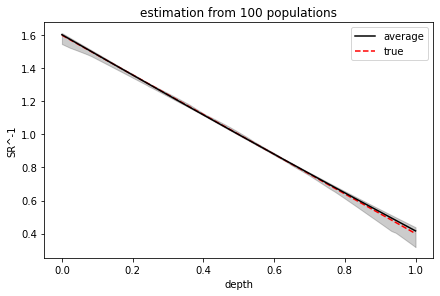

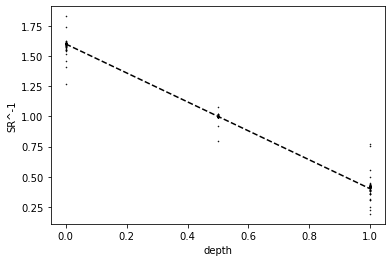

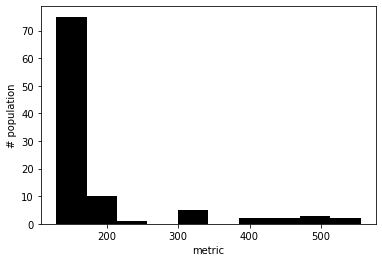

In [277]:
fig = plot_MPGA(invSR_all_para, metric_para)
fig.savefig("figures/test.png", dpi=200)

Sigmoid

In [299]:
fig.axes

[<AxesSubplot:title={'center':'estimation from 100 populations'}, xlabel='depth', ylabel='SR^-1'>]

(0.5, 1.5)

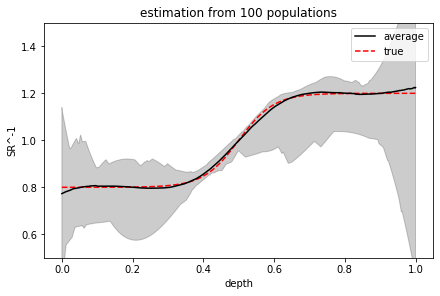

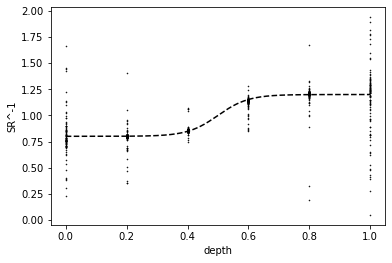

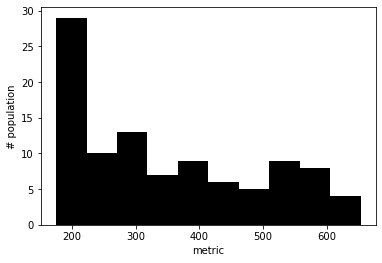

In [300]:
fig = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.5,1.5])

(0.6, 1.4)

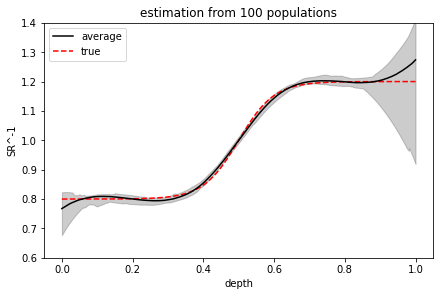

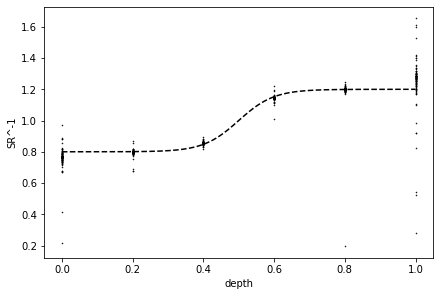

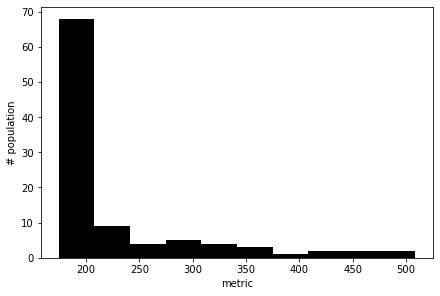

In [306]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])

(0.6, 1.4)

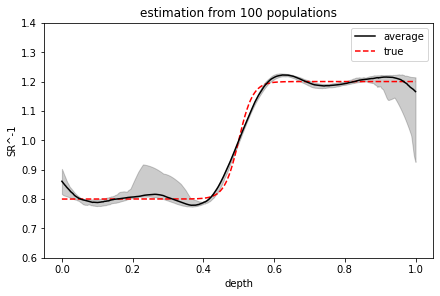

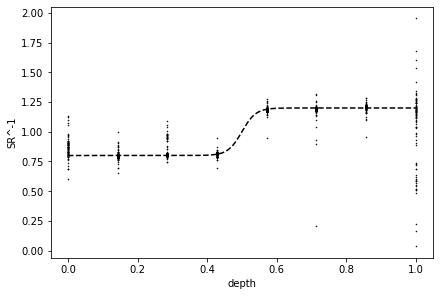

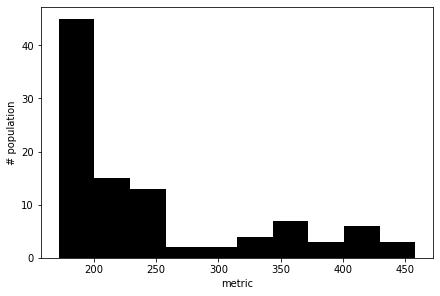

In [344]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])

Text(0, 0.5, '# population')

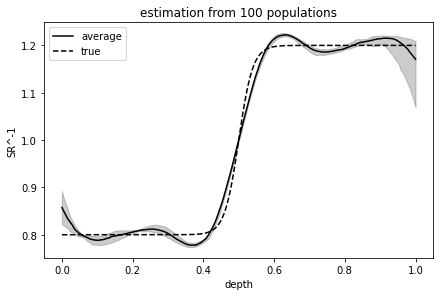

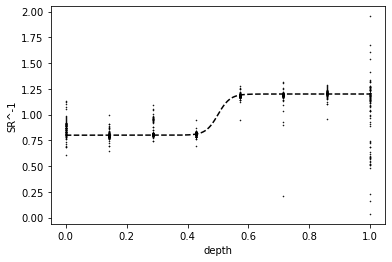

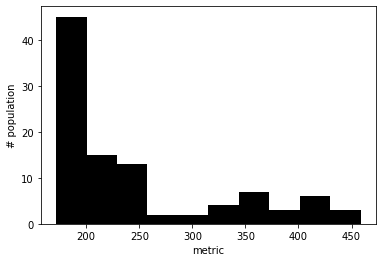

In [350]:
metric_last = np.array([metric_para[i][-1] for i in range(100)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
invSR_interpolate_par = invSR_interpolate_par[metric_best<300]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_all_populations_sigmoid_cubic.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")

plt.figure() 
plt.hist(metric_best, color="black")
plt.xlabel("metric")
plt.ylabel("# population")



Text(0, 0.5, '# population')

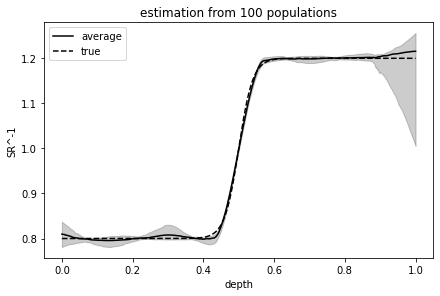

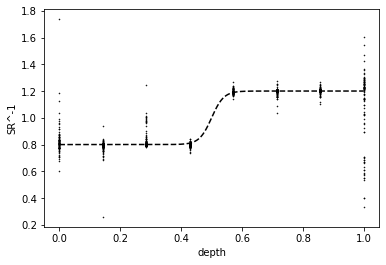

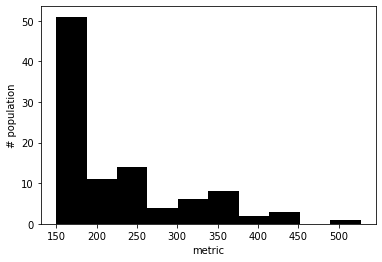

In [356]:
metric_last = np.array([metric_para[i][-1] for i in range(100)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<300]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.savefig("figures/invSR_all_populations_sigmoid_akima.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")

plt.figure() 
plt.hist(metric_best, color="black")
plt.xlabel("metric")
plt.ylabel("# population")



Sine

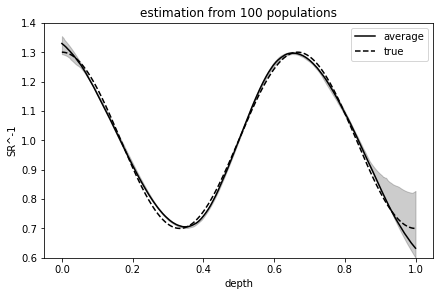

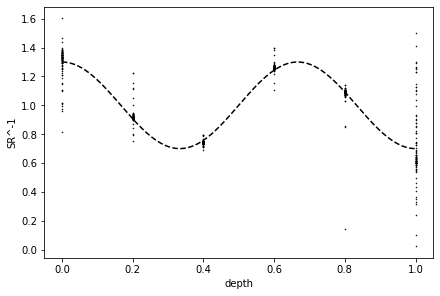

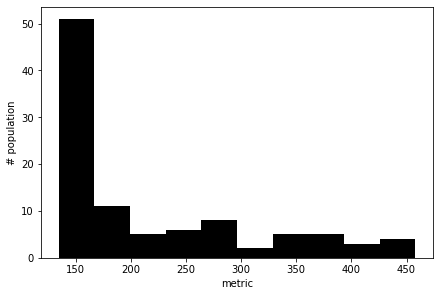

In [381]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


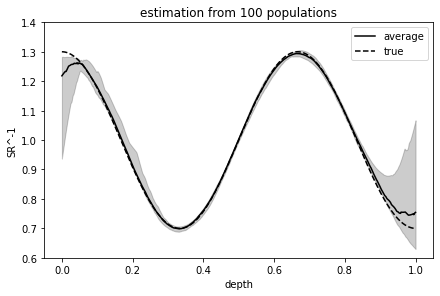

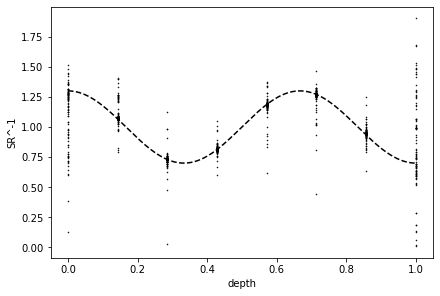

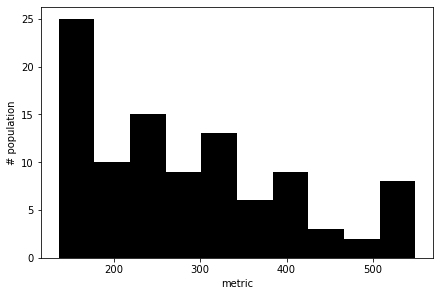

In [435]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
fig.savefig("figures/invSR_all_populations_sinek3.png", dpi=200)


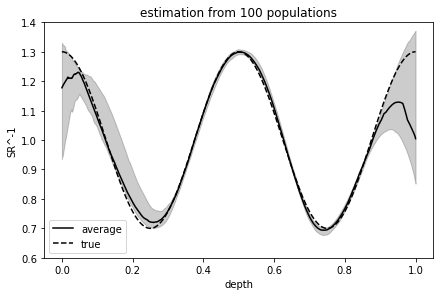

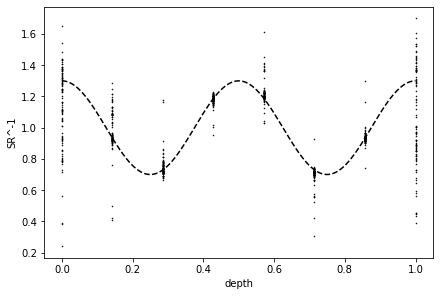

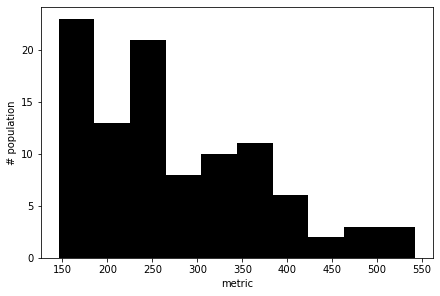

In [443]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
fig.savefig("figures/invSR_all_populations_sinek4.png", dpi=200)


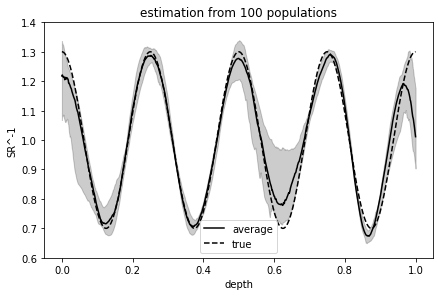

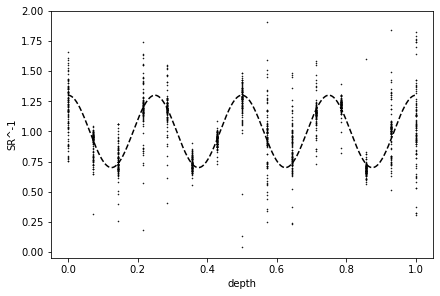

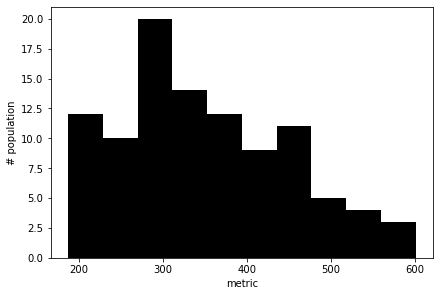

In [421]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
fig.savefig("figures/invSR_all_populations_sinek8.png", dpi=200)


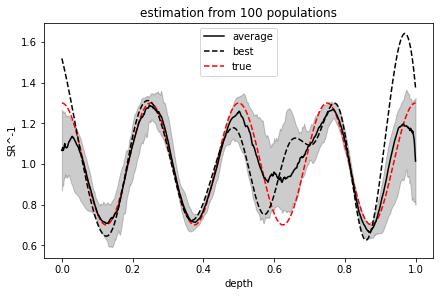

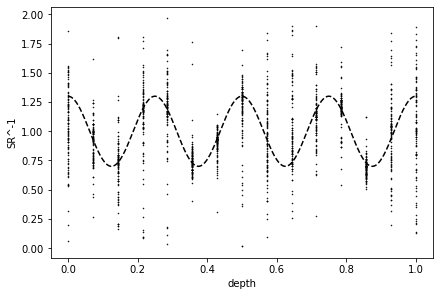

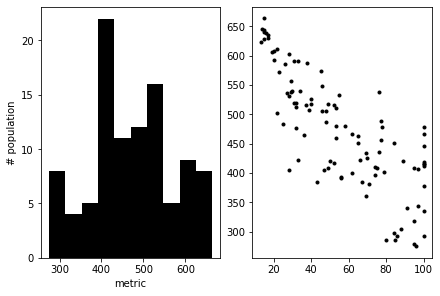

In [224]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.6,1.4])
# fig.savefig("figures/invSR_all_populations_sinek8.png", dpi=200)


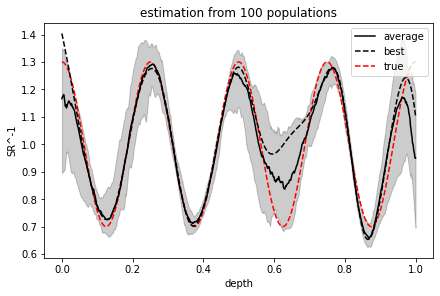

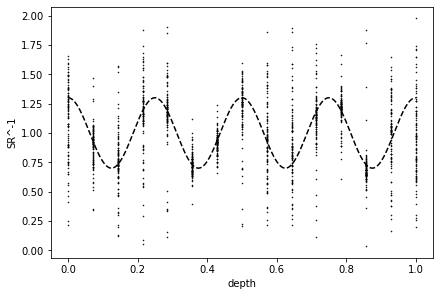

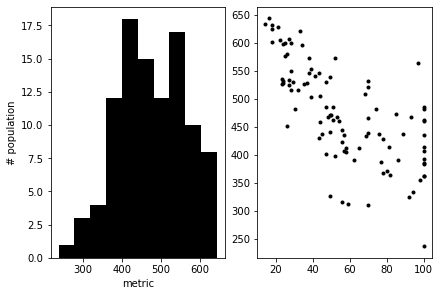

In [227]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.6,1.4])
# fig.savefig("figures/invSR_all_populations_sinek8.png", dpi=200)


Heart wave

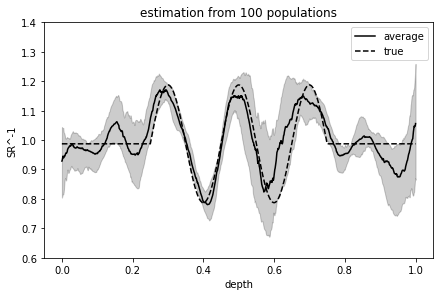

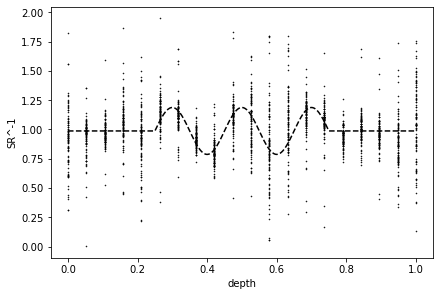

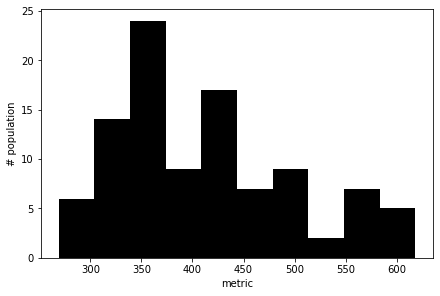

In [456]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
# fig.savefig("figures/invSR_all_populations_heartwave.png", dpi=200)


# Real data

In [23]:
data = pd.read_excel("ODP_Site_1260/ODP_Site_1260/ODP 1260_Fe_80-135.5m.xlsx")
data = data.values
depth = data[:,0]
ydata = data[:,1]

/obs/nhoanghoai/conda/myenv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [24]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
ydata_ma = moving_average(ydata, 400)
# ydata = ydata-ydata_ma
# ydata = ydata/ydata.std()

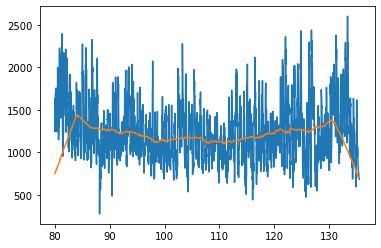

In [17]:
plt.plot(depth, ydata)
plt.plot(depth, ydata_ma)
# plt.plot(depth, ydata-ydata_ma)

In [25]:
ydata = ydata-ydata_ma
ydata = ydata/ydata.std()
ind = (depth>90) & (depth<125)
ydata = ydata[ind]
depth = depth[ind]
depth_original = depth
depth = (depth-depth[0])/(depth[-1]-depth[0])

In [19]:
N_population = 1000 # number of individual in population 
N_generations_max = 200
N_genes = 12 # number of intial gene in an individial of the population 
depth_grid = np.linspace(0,1,N_genes)
# depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])
# depth_grid = 0.5 + 0.5*np.cos((2*(np.arange(N_genes)+1)-1)/(2*N_genes)*np.pi); depth_grid = depth_grid[::-1]  #Chebysev nodes
invSR_lims = [0, 10]
fs = np.hstack([muy_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
y = ydata
interpolator = interpolate_CubicSpline
# metric_min = metric([depth_grid, func_inv_SR(depth_grid)], [depth, y], fs, interpolator, metric_type="BIC")
# print(metric_min)
invSR_all = np.zeros((N_generations_max, N_population, N_genes))
invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
invSR_all[0] = invSR_ini
metric_all = np.zeros((N_generations_max, N_population))
metric_ini = np.array([metric([depth_grid, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
metric_all[0] = metric_ini

In [20]:
kwargs = {
    "data": [depth, y],
    "fs" : fs,
    "interpolator":interpolator,
    "depth_grid":depth_grid,
    "N_population":N_population,
    "N_generations_max":N_generations_max,
    "invSR_lims":invSR_lims
}
 
GA_search_data = partial(GA_search,  **kwargs)
n_jobs = 100
n_total_population = 00
res = Parallel(n_jobs=n_jobs, verbose=100)(delayed(GA_search_data)() for _ in range(n_total_population))
invSR_all_para = [item[0] for item in res]
metric_para = [item[1] for item in res]

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
15
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:  1.1min
27
24
[Parallel(n_jobs=100)]: Done   3 out of 100 | elapsed:  1.9min remaining: 61.1min
27
23
[Parallel(n_jobs=100)]: Done   5 out of 100 | elapsed:  2.0min remaining: 38.6min
20
30
[Parallel(n_jobs=100)]: Done   7 out of 100 | elapsed:  2.1min remaining: 28.3min
31
22
[Parallel(n_jobs=100)]: Done   9 out of 100 | elapsed:  2.3min remaining: 23.5min
24
23
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:  2.4min remaining: 19.0min
24
35
[Parallel(n_jobs=100)]: Done  13 out of 100 | elapsed:  2.5min remaining: 16.8min
24
30
[Parallel(n_jobs=100)]: Done  15 out of 100 | elapsed:  2.6min remaining: 15.0min
39
26
[Parallel(n_jobs=100)]: Done  17 out of 100 | elapsed:  2.7min remaining: 13.3min
27
40
[Parallel(n_jobs=100)]: Done  19 out of 100 | elapsed:  2.8min remaining: 12.0min
40
39
[Parallel(n_jobs=100)]: Done  21 out of 100 | elapsed:  2

Plot

In [38]:
def plot_MPGA(invSR_all_para, metric_para):
    n_para = len(metric_para)
    metric_last = np.array([metric_para[i][-1] for i in range(n_para)])
    metric_best = metric_last.min(axis=1)
    
    # invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
    invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
    best_invSR = invSR_interpolate_par[np.argmin(metric_last.min(axis=1))]
    invSR_interpolate_par = invSR_interpolate_par[metric_best<-1300]
    # print(invSR_interpolate_par.shape)
    invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
    mean_invSR = np.median(invSR_interpolate_par,axis=0)
    invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)


    fig1 = plt.figure(constrained_layout=True)
    plt.title("estimation from 100 populations")
    plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
    plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
    plt.plot(depth, best_invSR,"--", zorder=10,color="black", label="best")
    # plt.plot(depth, invSR, "--", color="black", label="true")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")
    plt.legend()
    # plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

    fig2 = plt.figure(constrained_layout=True)
    [plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
    # plt.plot(depth, invSR, "--", color="black")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")

    fig3 = plt.figure(constrained_layout=True)
    plt.hist(metric_best, color="black")
    plt.xlabel("metric")
    plt.ylabel("# population")
    return fig1, fig2, fig3

(4, 1693)


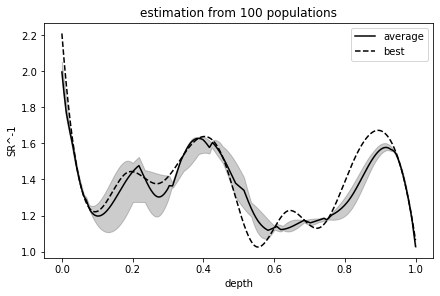

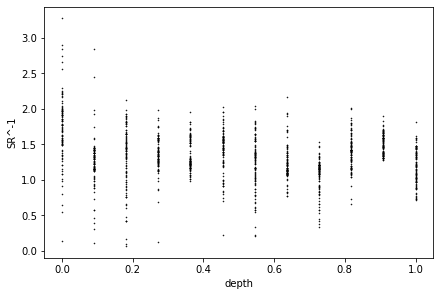

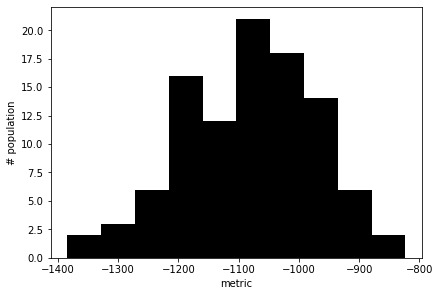

In [39]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


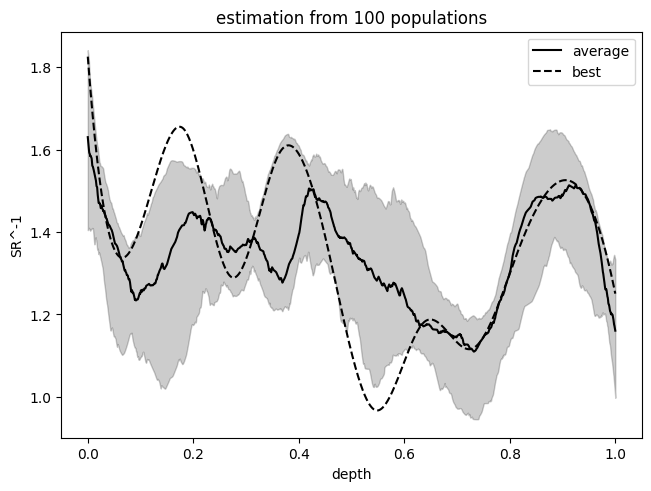

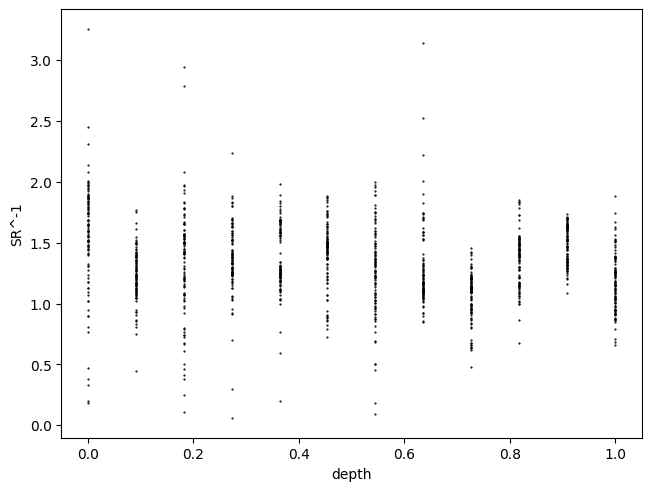

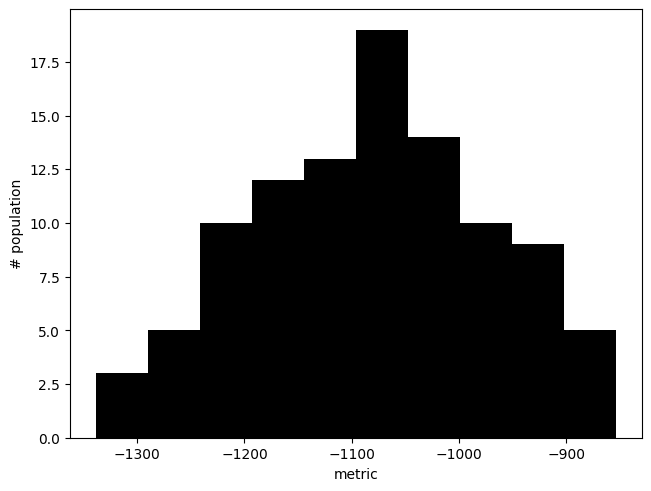

In [580]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


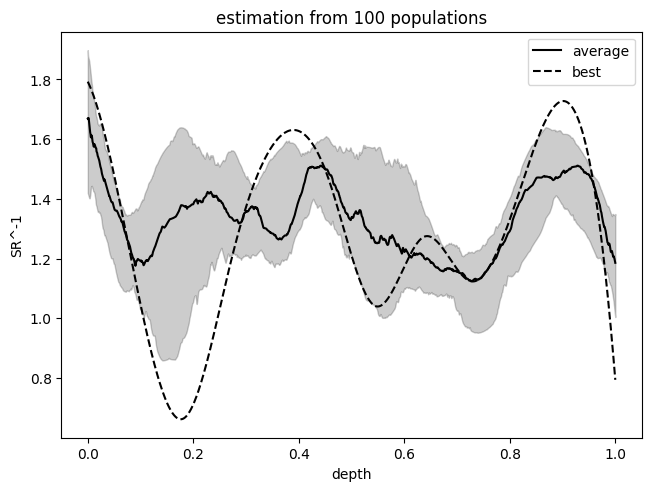

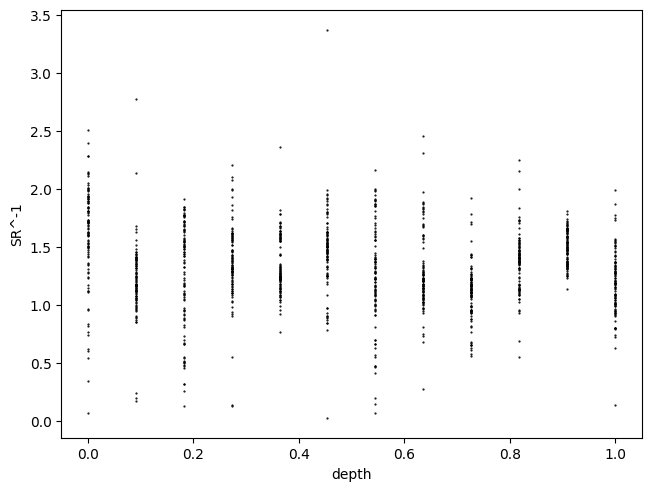

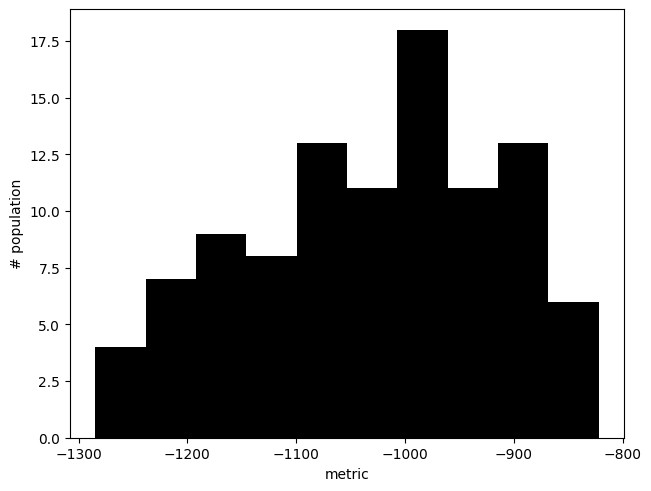

In [572]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


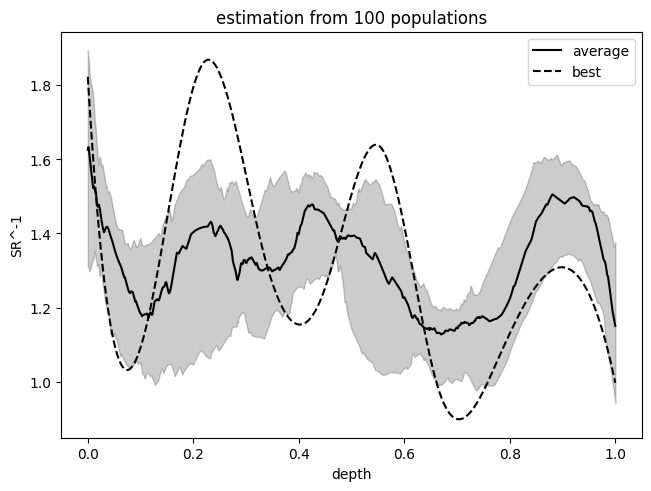

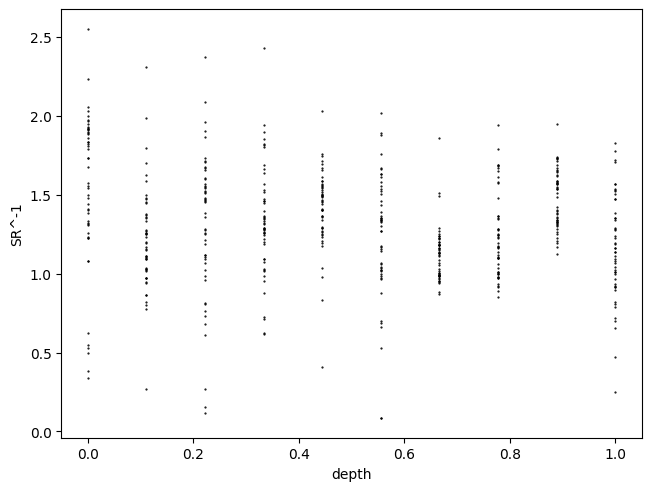

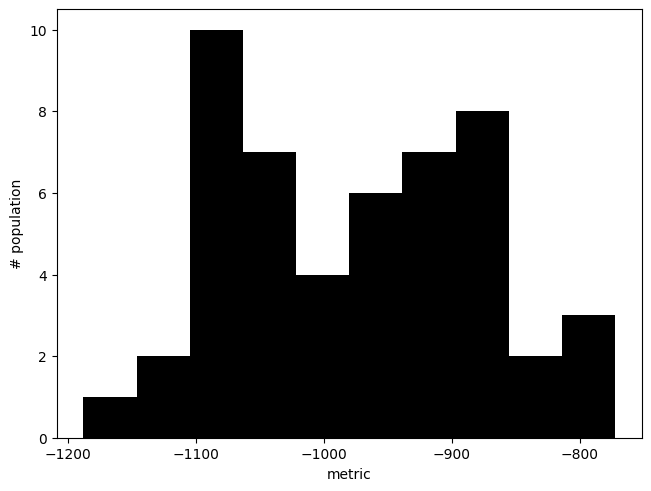

In [527]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


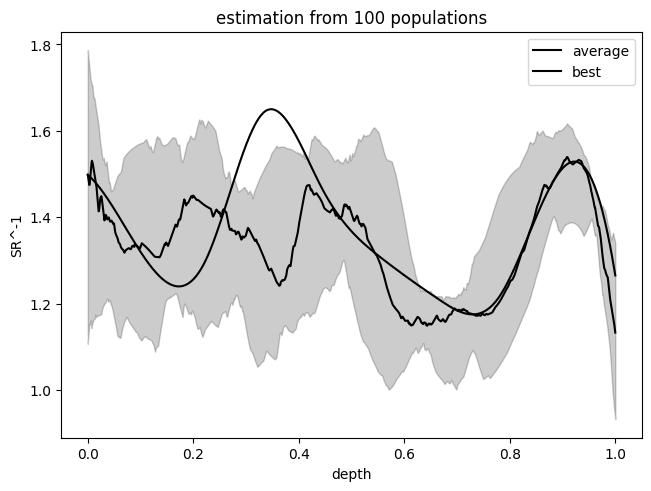

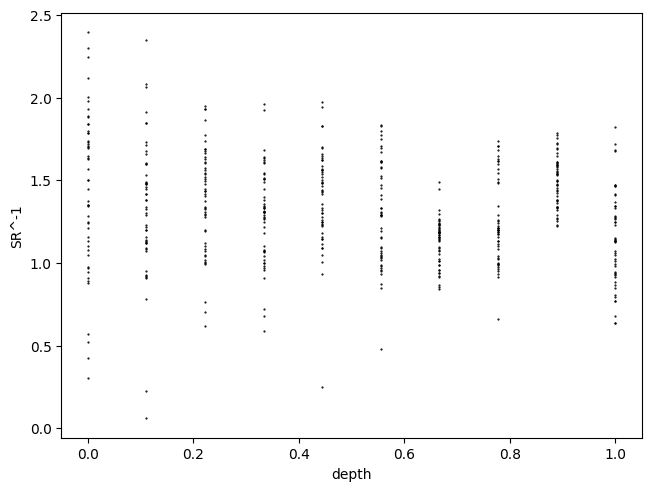

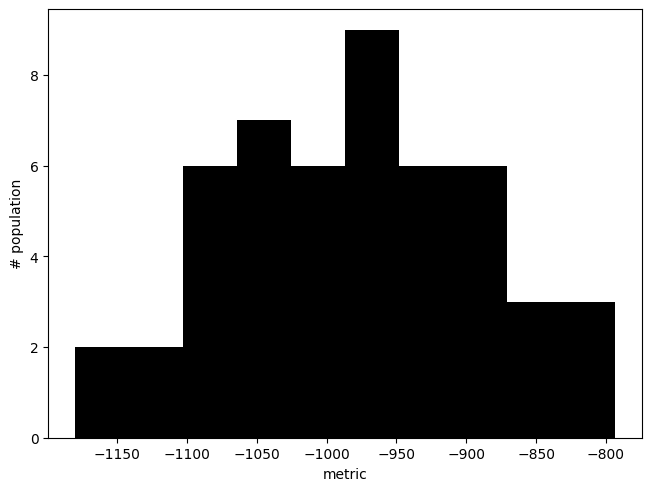

In [482]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


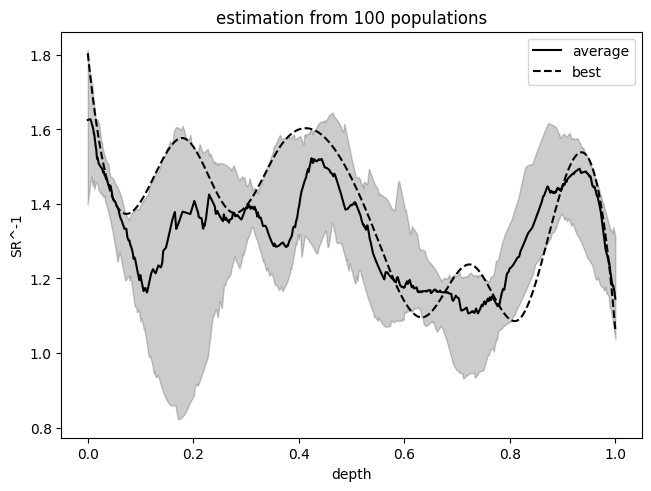

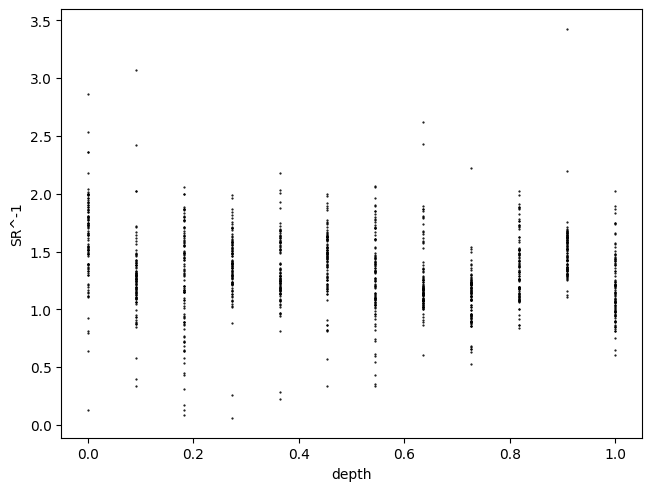

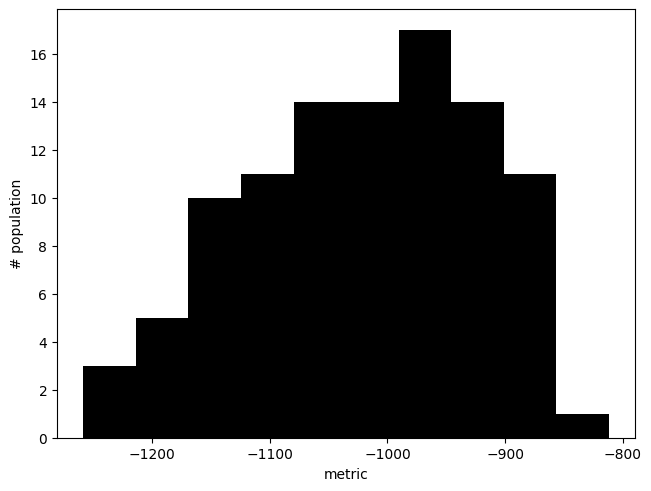

In [503]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


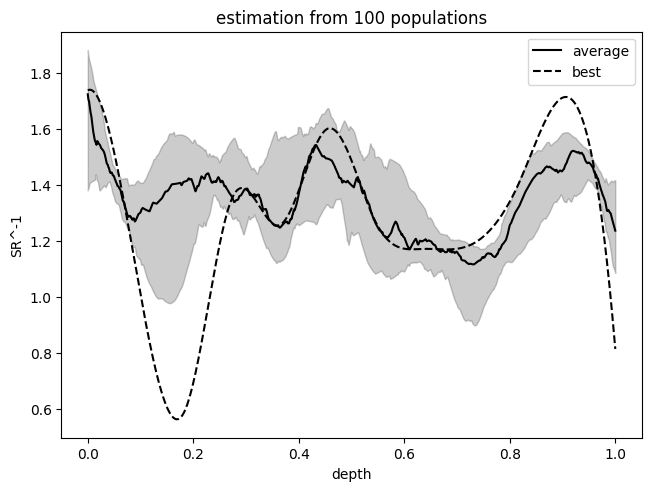

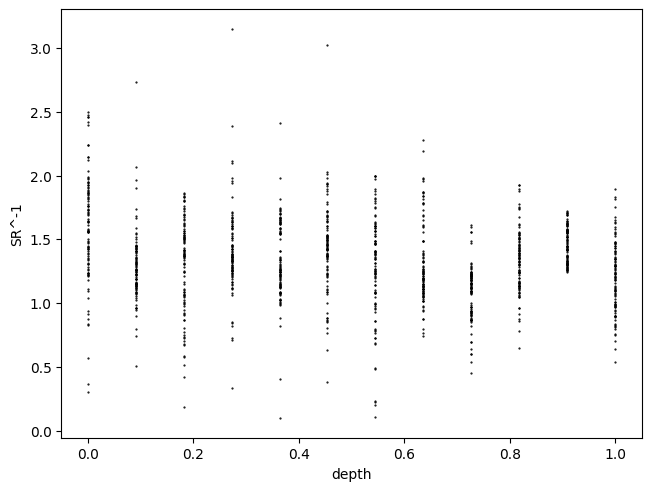

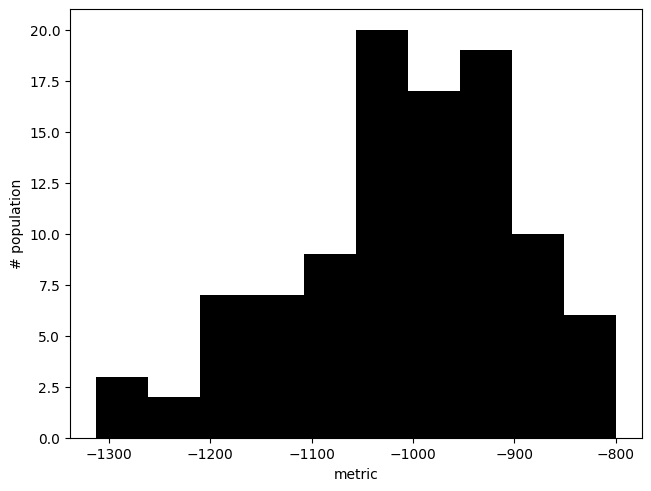

In [507]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
# fig.axes[0].set_ylim([0.,10])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


In [45]:
metric_best.shape, invSR_all.shape

((100,), (100, 1693))

In [51]:
# len(invSR_all_para)
invSR_all_para[2].shape


In [28]:
n_para = len(metric_para)
metric_last = np.array([metric_para[i][-1] for i in range(n_para)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]
len_par = np.array([invSR_all.shape[0] for i, invSR_all in enumerate(invSR_all_para)])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
best_invSR = invSR_interpolate_par[np.argmin(metric_last.min(axis=1))]

In [32]:
# invSR_interpolate = interpolator([depth_grid, mean_invSR], depth)
# invSR_interpolate[invSR_interpolate<0] = 0
# invSR = invSR_interpolate_par[2]
invSR = best_invSR
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
X = generate_X_linReg(np.ones_like(fs), fs, time)

reg_model = LinearRegression().fit(X, ydata)
# Residual Sum Square
# RSS = np.sum((y_data - reg_model.predict(X))**2)

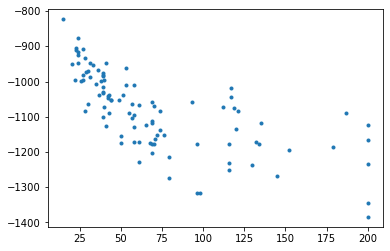

In [55]:
plt.plot(len_par, metric_best, '.')

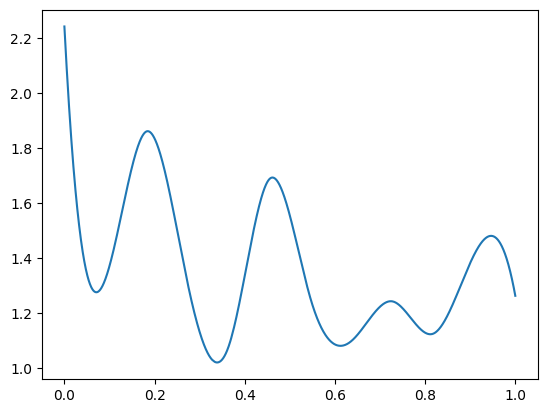

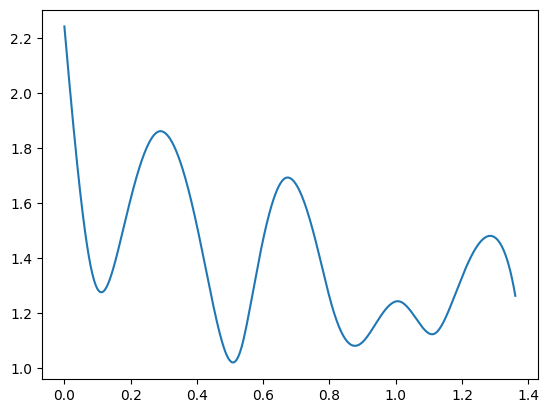

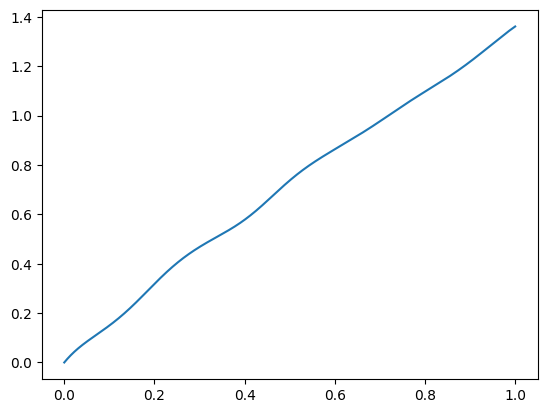

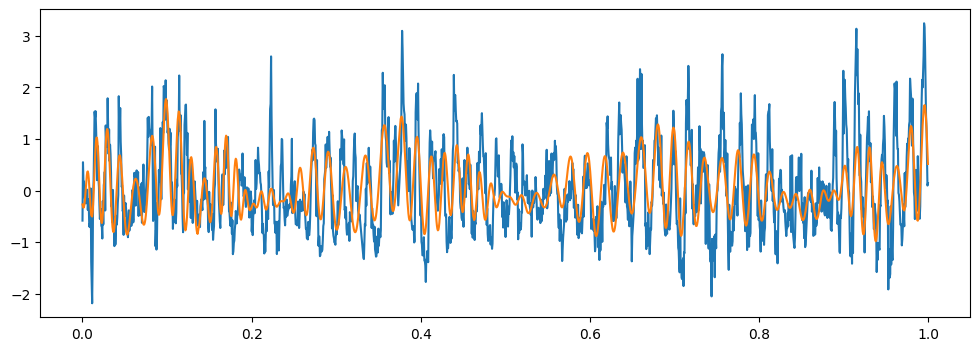

In [520]:
plt.figure()
plt.plot(depth, invSR)
plt.figure()
plt.plot(time, invSR)
plt.figure()
plt.plot(depth, time)
plt.figure(figsize=(12,4))
plt.plot(depth, ydata)
plt.plot(depth, reg_model.predict(X))


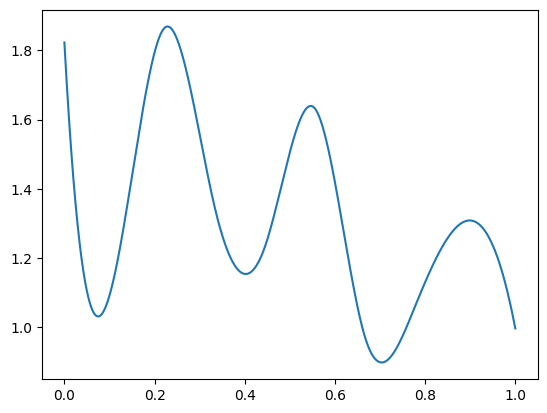

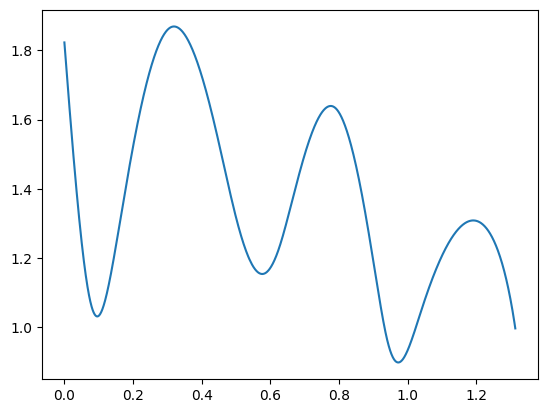

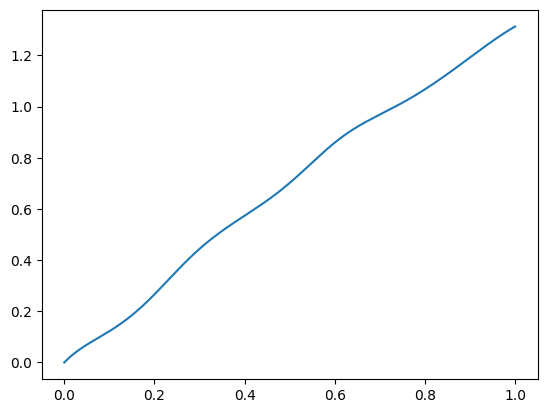

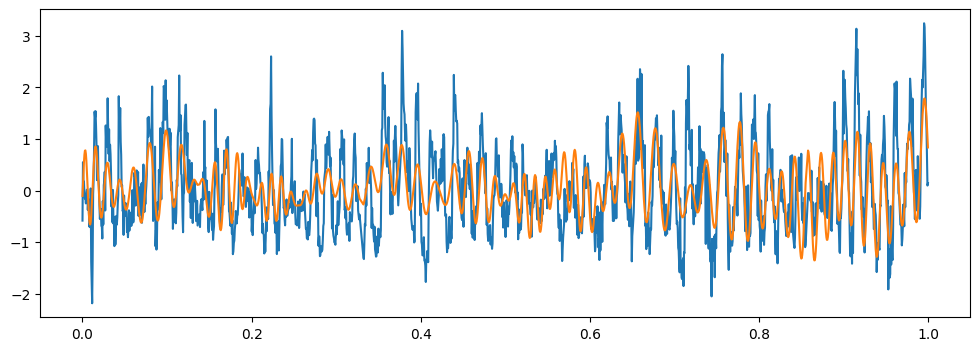

In [534]:
plt.figure()
plt.plot(depth, invSR)
plt.figure()
plt.plot(time, invSR)
plt.figure()
plt.plot(depth, time)
plt.figure(figsize=(12,4))
plt.plot(depth, ydata)
plt.plot(depth, reg_model.predict(X))


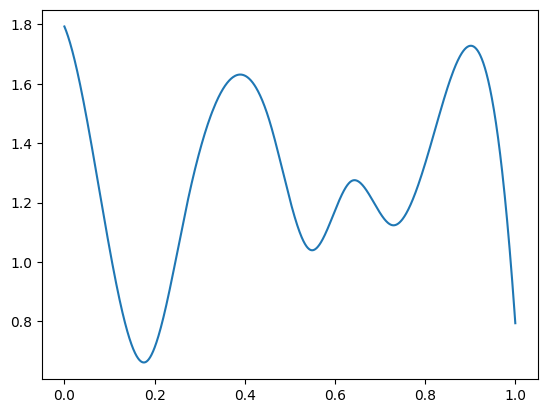

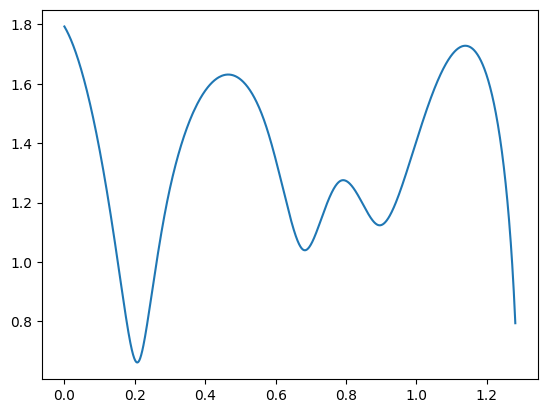

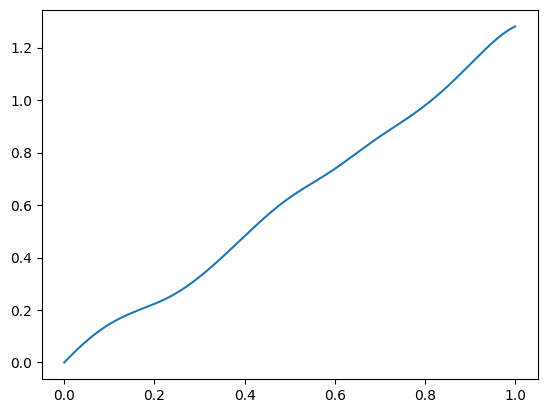

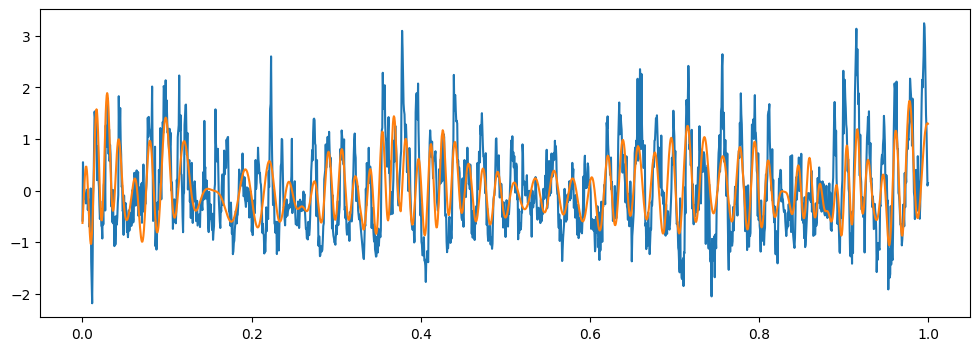

In [577]:
plt.figure()
plt.plot(depth, invSR)
plt.figure()
plt.plot(time, invSR)
plt.figure()
plt.plot(depth, time)
plt.figure(figsize=(12,4))
plt.plot(depth, ydata)
plt.plot(depth, reg_model.predict(X))


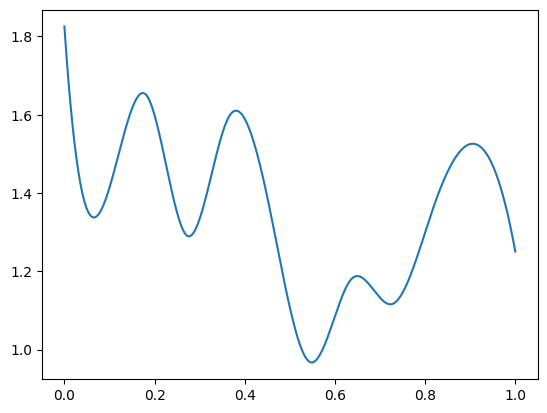

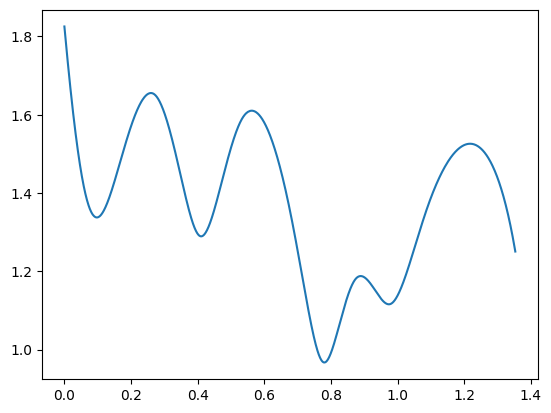

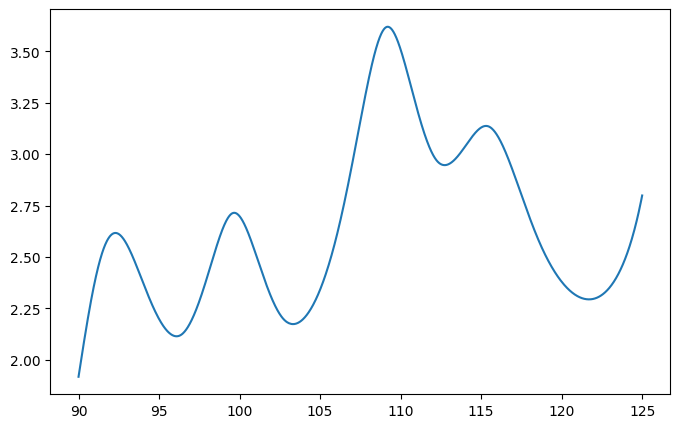

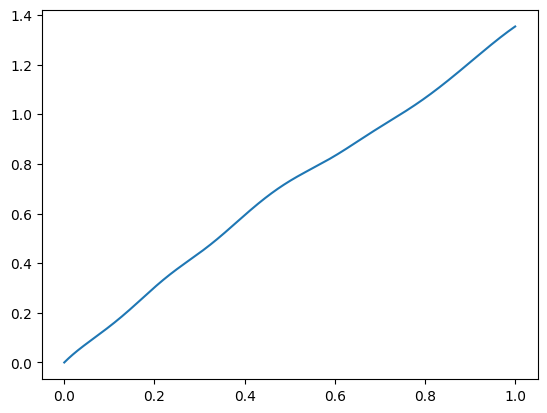

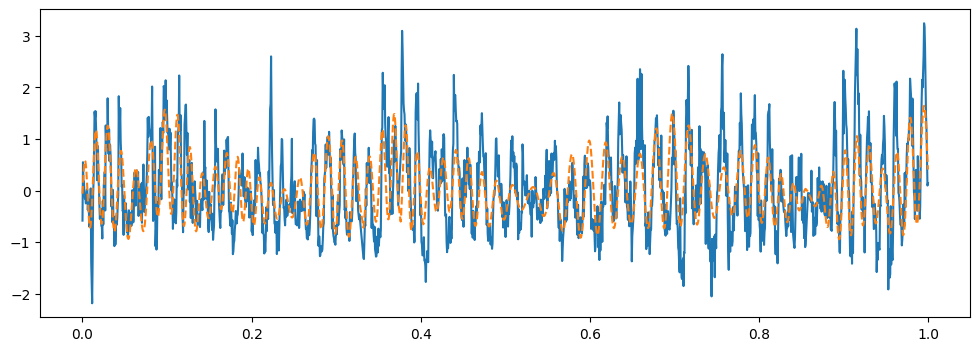

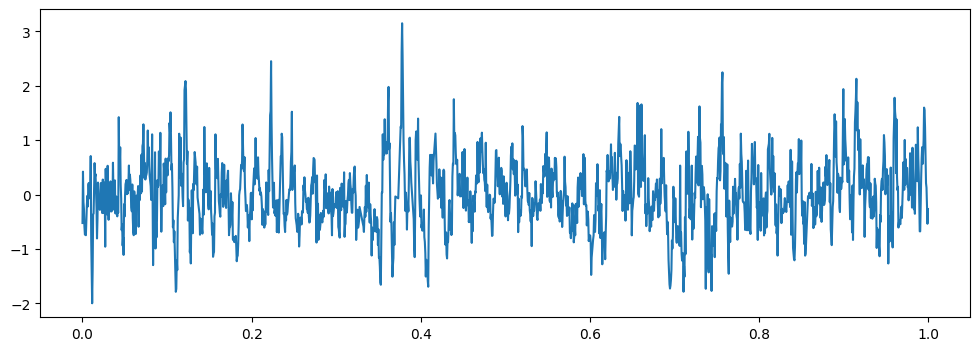

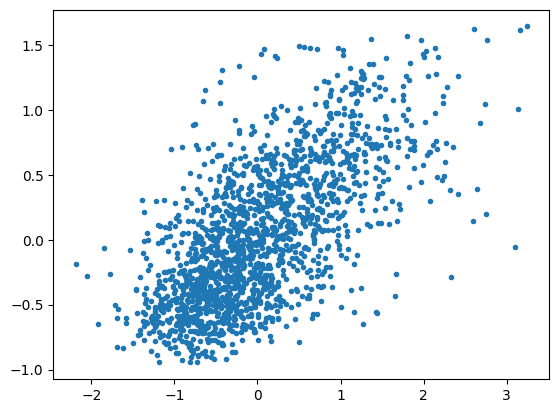

: 

In [614]:
plt.figure()
plt.plot(depth, invSR)
plt.figure()
# plt.subplot(1,2,1)
plt.plot(time, invSR)
# plt.subplot(1,2,2)
plt.figure(figsize=(8,5))
plt.plot(depth_original, 1/invSR*3.5)
plt.figure()
plt.plot(depth, time)
plt.figure(figsize=(12,4))
plt.plot(depth, ydata)
plt.plot(depth, reg_model.predict(X), "--")
plt.figure(figsize=(12,4))
# plt.plot(depth, ydata)
plt.plot(depth, ydata-reg_model.predict(X))
plt.figure()
plt.plot(ydata, reg_model.predict(X), ".")


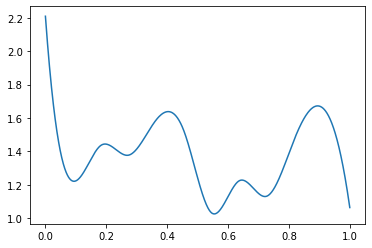

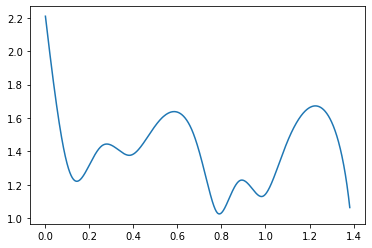

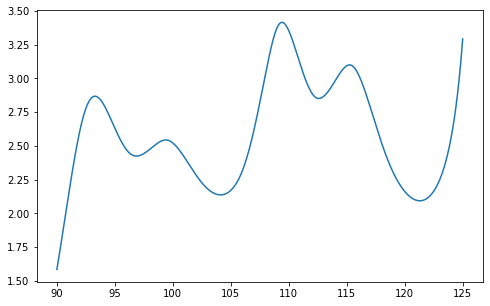

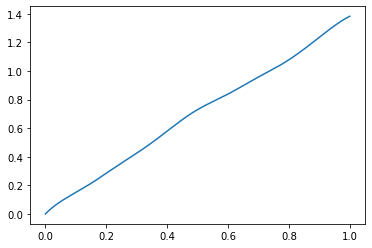

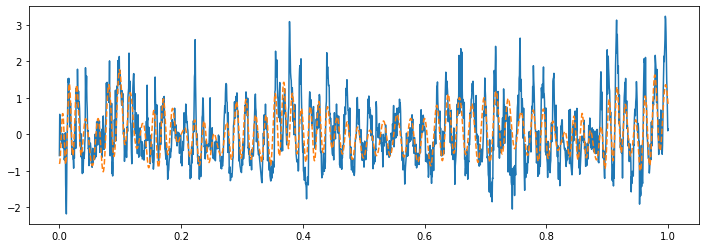

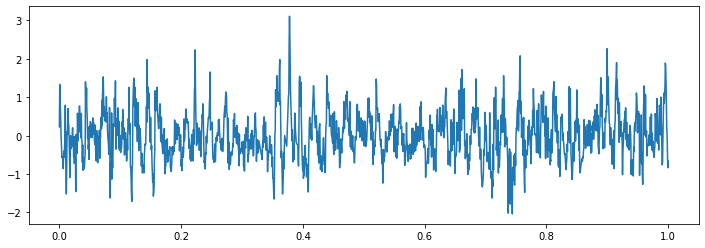

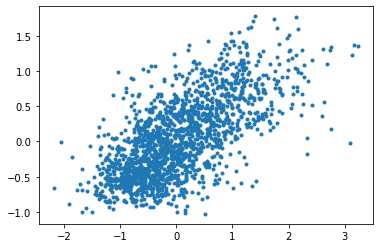

In [33]:
plt.figure()
plt.plot(depth, invSR)
plt.figure()
# plt.subplot(1,2,1)
plt.plot(time, invSR)
# plt.subplot(1,2,2)
plt.figure(figsize=(8,5))
plt.plot(depth_original, 1/invSR*3.5)
plt.figure()
plt.plot(depth, time)
plt.figure(figsize=(12,4))
plt.plot(depth, ydata)
plt.plot(depth, reg_model.predict(X), "--")
plt.figure(figsize=(12,4))
# plt.plot(depth, ydata)
plt.plot(depth, ydata-reg_model.predict(X))
plt.figure()
plt.plot(ydata, reg_model.predict(X), ".")


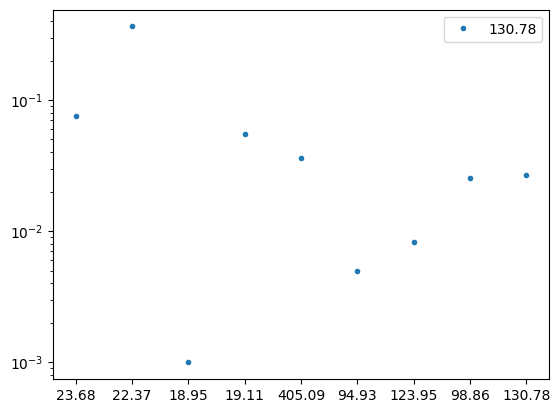

In [610]:
Amps = reg_model.coef_[:len(fs)]**2+reg_model.coef_[len(fs):]**2
# plt.plot(np.pi/fs*2*1e3, Amps, '.')
# for i in range(len(fs)):
plt.plot(Amps, '.', label=f"{np.pi/fs[i]*2*1e3:.2f}")
plt.xticks(range(len(fs)), [f"{np.pi/fs[i]*2*1e3:.2f}" for i in range(len(fs))])
plt.yscale("log")
plt.legend()

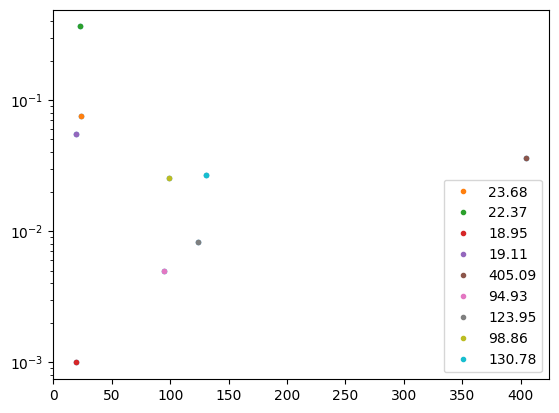

In [597]:
Amps = reg_model.coef_[:len(fs)]**2+reg_model.coef_[len(fs):]**2
plt.plot(np.pi/fs*2*1e3, Amps, '.')
for i in range(len(fs)):
    plt.plot(np.pi/fs[i]*2*1e3, Amps[i], '.', label=f"{np.pi/fs[i]*2*1e3:.2f}")
plt.yscale("log")
plt.legend()

In [599]:
np.pi/fs*2*1e3

array([ 23.68192456,  22.37399749,  18.95348896,  19.10537518,
       405.09127213,  94.93170191, 123.94531716,  98.85732074,
       130.78122914])